参考: 

https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification

https://www.kaggle.com/code/werus23/g2net-pytorch-with-generated-data

In [1]:
# たまにgpu取れないときあるので取れないときは終わらせる
import torch
if torch.cuda.is_available() == False:
    raise Exception

In [2]:
!nvidia-smi

Sat Dec 10 22:54:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1D:00.0 Off |                    0 |
| N/A   32C    P0    39W / 300W |      3MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# papermill parameters
cfg_optimizer = "adamw" # "sam"
device_ids = [0]
epochs = 15
gradient_accumulation_steps = 1
is_syncBN = False

#lr = 5e-3  # 高すぎるみたい
lr = 4e-4

warmup_t = 3
#warmup_t = 1

min_lr_ratio = 1e-2

weight_decay = 1e-5  # 1e-6にしてもほぼ変わらない
#weight_decay = 1e-6

is_wandb = True
is_wandb = False
n_seeds = 1
cfg_seeds = [0]

cfg_apex = True
#cfg_apex = False  # ampなしにしても変わらず

#BATCH_SIZE = 2
#BATCH_SIZE = 8  # 8にしても16と変わらず学習遅くなるだけ
BATCH_SIZE = 16
#BATCH_SIZE = 32  # 32以降ぐらいからbatch上げるとepochごとのスコア安定しない
#BATCH_SIZE = 64
#BATCH_SIZE = 128
#BATCH_SIZE = 384

load_model_path = "none"
#load_model_path = "/volume/kaggle/g2net2/output/tmp/tmp_fold0_seed0_best_score.pth"
#model_cls = "CustomModel"
#model_cls = "CustomModelDrop"
model_cls = "CustomModelMultiOutput"
#model_cls = "CustomModelMultiInput"
#model_cls = "CustomModelLargeKernel"

# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook
cfg_drop_rate = 0.4
cfg_drop_path_rate = 0.2

#MODEL_NAME = ""
MODEL_NAME = "mobilenetv3_small_050"
#MODEL_NAME = "tf_efficientnetv2_b1"
#MODEL_NAME = "tf_efficientnet_b4_ap"
#MODEL_NAME = "tf_efficientnet_b5_ns"
#MODEL_NAME = "tf_efficientnet_b7_ns"
#MODEL_NAME = "seresnext101d_32x8d"
cfg_pretrained = True

n_fold = 5
#trn_fold = [0,1,2,3,4]
#is_trn_allfold = True
trn_fold = [0]
#trn_fold = "[3]"
is_trn_allfold = False

cfg_scheduler = 'CosineLRScheduler'  # warmup
#cfg_scheduler = 'CosineLRScheduler_cycle_limit3'  # warmup

# data params
cfg_ch = 2
#cfg_step = 64
cfg_step = 128
#cfg_step = 256
#cfg_step = 340
#cfg_step = 512
#cfg_step = 5760
cfg_spec_max = 4096
#cfg_spec_max = 4224  # 33 * 128
#cfg_spec_max = 5760

size_h, size_w = 360, cfg_step
#size_h, size_w = 360, 128
#size_h, size_w = 360, 256

# train+test set stat img  https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-img4096
# np.mean(p.reshape(freq, step, spec_max//step), axis=2)直後の統計値
cfg_p_mean = [2.4080, 2.3525]  # [H1, L1]
cfg_p_std = [0.6578, 0.8358]  # [H1, L1]

#normalize_type = "default-norm|ts-ma"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-max"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|ts-ma|p-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel|p-stand|ts-ma"
#normalize_type = "largekernel"

cfg_is_add_ch = False
cfg_is_train_zip_dataset = False
cfg_prob_mixup = 0.0

#cfg_prob_sample_mixup = 0.0
#cfg_prob_sample_mixup = 0.5
cfg_prob_sample_mixup = 0.8

cfg_is_sample_mixup_use_pseudo = True
#cfg_is_sample_mixup_use_pseudo = False

cfg_prob_add_sample_nega_mixup = 0.0
#cfg_prob_add_sample_nega_mixup = 0.5

#cfg_prob_mean_mixup = 0.0
cfg_prob_mean_mixup = 0.3

#cfg_prob_noise_band = 0.0
cfg_prob_noise_band = 0.3

#cfg_prob_noise_spot = 0.0
cfg_prob_noise_spot = 0.05

#cfg_prob_noise_vline = 0.0
cfg_prob_noise_vline = 0.2

#cfg_prob_noise_hband = 0.0
cfg_prob_noise_hband = 0.2
cfg_prob_noise_hband = 0.5

cfg_prob_spec_start_random = 0.0
#cfg_prob_spec_start_random = 0.5

#cfg_prob_swap_ch_nega = 0.0
cfg_prob_swap_ch_nega = 0.5

#cfg_prob_flip_nega = 0.0
cfg_prob_flip_nega = 0.5

#cfg_prob_swap_nega = 0.0
cfg_prob_swap_nega = 0.5

cfg_prob_vshift_nega = 0.0
#cfg_prob_vshift_nega = 0.5

#cfg_prob_vshift = 0.0
cfg_prob_vshift = 1.0

#cfg_freq_mask_num = 0  # マスクする横線
#cfg_time_mask_num = 0  # マスクする縦線
cfg_freq_mask_num = 2
cfg_time_mask_num = 1
cfg_freq_mask_param = 10
cfg_time_mask_param = 10
#cfg_freq_mask_param = 30
#cfg_time_mask_param = 50

cfg_cv_col = "target"
#cfg_cv_col = "freq_min//10"
#cfg_cv_col = "freq_min//10_target"

cfg_add_split_str = ""
#cfg_add_split_str = "KFold"
#cfg_add_split_str = "StratifiedKFold"

cfg_is_npy = True
#cfg_is_npy = False

FCOFF = 1e22
#FCOFF = 5e22

ADD_DIRS_STR = ""
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL, EX004_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL1, EX005_SIGNAL_ISO1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX003_NOISE2, EX004_SIGNAL, EX004_SIGNAL_ISO, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX006_SIGNAL800]"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

IS_ADD_ALL_TRAIN1 = False
#IS_ADD_ALL_TRAIN1 = True


PSEUDO_CSV = ""
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1
#cfg_pseudo_max = 0.0  # pseudoの閾値なし
#cfg_pseudo_min = 0.0  # pseudoの閾値なし
#cfg_is_pseudo_hard = True
cfg_is_pseudo_hard = False

cfg_pseudo_type = ""
#cfg_pseudo_type = "real"
#cfg_pseudo_type = "sim"


ADD_PSEUDO_DIRS = ""
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"


cfg_freq_div_n = 10
#cfg_freq_div_n = 50
#cfg_freq_div_n = 100


is_matplotlib_agg = False
#is_matplotlib_agg = True  # 可視化なしにする

IS_MAKE_SUB = False
#IS_MAKE_SUB = True

#DEBUG = False
DEBUG = True

add_name = ""

In [4]:
# Parameters
add_name = "_pseudo_multioutput_freq_b5_ap_freq_div_n50"
BATCH_SIZE = 64
MODEL_NAME = "tf_efficientnet_b5_ap"
model_cls = "CustomModelMultiOutput"
epochs = 50
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
cfg_apex = True
cfg_step = 128
size_w = 128
cfg_is_sample_mixup_use_pseudo = True
cfg_add_split_str = "StratifiedKFold"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1
cfg_is_pseudo_hard = False
cfg_freq_div_n = 50
IS_ADD_ALL_TRAIN1 = False
IS_MAKE_SUB = True
n_fold = 5
is_trn_allfold = True
DEBUG = False


In [5]:
# papermillで引数をlistで渡さなかった場合の対策
if isinstance(device_ids, int):
    device_ids = [0]
    
# trn_foldをpapermillで渡したときの対策
if type(trn_fold) is str:
    trn_fold = eval(trn_fold)
    
# 全fold学習
if is_trn_allfold:
    trn_fold = list(range(n_fold))
    
# 複数seedで学習
if n_seeds > 1:
    cfg_seeds = list(range(n_seeds))
    
# ダウンロードしたデータで事前学習する場合はfold=0のみ
if cfg_is_train_zip_dataset:
    trn_fold = [0]
    
# フラグあればch増やす
if cfg_is_add_ch:
    cfg_ch = 2 + 2 
    
# 移動平均の場合は画像の横幅-1する
if "ts-ma" in normalize_type:
    size_w -= 1
    
# フーリエ係数変える場合
if FCOFF != 1e22:
    normalize_type += f"_{str(FCOFF)}"
    
## largekernelを使う場合
#if "largekernel" in normalize_type:
#    cfg_spec_max = 5760
    
# LargeKernelモデルを使う場合
if model_cls == "CustomModelLargeKernel":
    MODEL_NAME = ""
    cfg_step = 5760
    cfg_spec_max = 5760
    size_h, size_w = 360, cfg_step
    normalize_type = "largekernel"
    cfg_prob_mean_mixup = 0.0
    cfg_prob_spec_start_random = 0.0
    cfg_time_mask_param = int( 10 * (cfg_spec_max / 128) )

In [6]:
#import ipynbname
#NAME = ipynbname.name()
if DEBUG:
    NAME = f"tmp"
    #NAME = f"tmp_real"
    #NAME = f"tmp_no-alb"
    #NAME = f"tmp_VerticalFlip"
    #NAME = f"tmp_HorizontalFlip"
    #NAME = f"tmp_no-alb_EX003_NOISE01"
else:
    NAME = f"kqi_3090_ex075_v2{add_name}"
print(NAME)

kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50


# Directory

In [7]:
import os, sys

if "kaggle_web_client" in sys.modules:
    INPUT_DIR_TRAIN = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    INPUT_DIR_TEST = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"

elif "/work" in os.getcwd():
    INPUT_DIR_TRAIN = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    INPUT_DIR_TEST = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    OUTPUT_DIR = f"/volume/kaggle/g2net2/output/{NAME}"  # HDD
    
    # ============================================
    # 生成データのパス
    # ============================================
    EX003_NOISE = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex003_generating_noise_gap5000"  # HDD 5000件
    EX004_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_1"  # HDD 800件
    EX005_SIGNAL_ISO1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_iso_1"  # HDD 800件
    EX006_NOISE1400 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap1400"  # HDD 1400件
    EX006_SIGNAL800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap800"  # HDD 800件
    EX006_SIGNAL_ISO800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso800"  # HDD 800件
    EX006_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap5000"  # HDD 5000件
    EX006_SIGNAL2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap2000"  # HDD 2000件
    EX006_SIGNAL_ISO2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso2000"  # HDD 2000件
    EX007_NONSTAT_NOISE800 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary800"  # HDD 800件
    EX007_NONSTAT_NOISE1000 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary1000"  # HDD 1000件
    EX008_SIGNAL_D5075_400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_400"  # HDD 400件
    EX008_SIGNAL_D5075_ISO400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_iso400"  # HDD 400件
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/volume-ssd/kaggle_g2net2/npys"  # SSD
    

elif "/kqi/output" in os.getcwd():
    INPUT_DIR_TRAIN = f"/workspace/g2net2/input"  # cp_SSD
    INPUT_DIR_TEST = f"/kqi/output/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"
    
    # ============================================
    # 生成データのパス
    # ============================================
    _dir = f"/workspace/g2net2/pyfstat_output/{normalize_type}"
    EX003_NOISE = f"{_dir}/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"{_dir}/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"{_dir}/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"{_dir}/ex003_generating_noise_gap5000"  # SSD 5000件
    EX004_SIGNAL = f"{_dir}/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"{_dir}/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"{_dir}/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"{_dir}/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"{_dir}/ex005_generating_signal_gap_1"  # SSD 800件
    EX005_SIGNAL_ISO1 = f"{_dir}/ex005_generating_signal_gap_iso_1"  # SSD 800件
    EX006_NOISE1400 = f"{_dir}/ex006_generating_noise_gap1400"  # SSD 1400件
    EX006_SIGNAL800 = f"{_dir}/ex006_generating_signal_gap800"  # SSD 800件
    EX006_SIGNAL_ISO800 = f"{_dir}/ex006_generating_signal_gap_iso800"  # SSD 800件
    EX006_NOISE5000 = f"{_dir}/ex006_generating_noise_gap5000"  # SSD 5000件
    EX006_SIGNAL2000 = f"{_dir}/ex006_generating_signal_gap2000"  # SSD 2000件
    EX006_SIGNAL_ISO2000 = f"{_dir}/ex006_generating_signal_gap_iso2000"  # SSD 2000件
    EX007_NONSTAT_NOISE800 = f"{_dir}/ex007_generating_noise_nonstationary800"  # SSD 800件
    EX007_NONSTAT_NOISE1000 = f"{_dir}/ex007_generating_noise_nonstationary1000"  # SSD 1000件
    EX008_SIGNAL_D5075_400 = f"{_dir}/ex008_generating_signal_d5075_400"  # SSD 400件
    EX008_SIGNAL_D5075_ISO400 = f"{_dir}/ex008_generating_signal_d5075_iso400"  # SSD 400件
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/workspace/g2net2/pyfstat_output"  # SSD
    
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(OUTPUT_DIR)

./output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50


# Data

In [8]:
import os, sys
import shutil
import cv2
import glob
import random
import h5py
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler

pd.set_option('display.max_columns', None)

if is_matplotlib_agg:
    import matplotlib
    matplotlib.use('Agg')
    from matplotlib import pyplot as plt
else:
    from matplotlib import pyplot as plt

In [9]:
%reload_ext autoreload
%autoreload 2
from src.zip_dataset import ZipDataset
from src import largekernel

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [10]:
if cfg_is_train_zip_dataset:
    
    zip_path = f'{INPUT_DIR_TRAIN}/../g2net-generated-signals'
    zip_mod = 100
    zip_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod)
    
    # ZipDatasetのラベルをcsvにしておく
    if os.path.exists(f'{zip_path}/zip_df.csv') == False:
        zip_labels = []
        zip_paths = []
        for i, (img, y) in tqdm(enumerate(zip_dataset), total=len(zip_dataset)):
            y = int(y)
            zip_labels.append(y)
            zip_paths.append(f'{zip_path}/archive/{y}_data_{zip_mod*(1+(i)//zip_mod)}/signals_{i%zip_mod}.npy')
            if i == 14900-1:
                break
        zip_df = pd.DataFrame({"id": range(len(zip_labels)), 
                               "target": zip_labels,
                               "path": zip_paths,
                               "fold": -1,
                              })
        zip_df.to_csv(f'{zip_path}/zip_df.csv', index=False)
        

#train_df = pd.read_csv(INPUT_DIR_TRAIN + '/train_labels.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
train_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/train_summary.csv").rename(columns={"Unnamed: 0":'id'})
train_df["path"] = INPUT_DIR_TRAIN + "/train/" + train_df["id"] + ".hdf5"
train_df = train_df[train_df.target >= 0]  # Remove 3 unknowns (target = -1)
train_df["orig"] = 1  # オリジナルデータのフラグ
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
train_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/train_mean_std.csv").drop(['target'], axis=1)
train_df = pd.merge(train_df, train_ma_img_mean_std, on="id")
print("train_df.shape:", train_df.shape)
#display(train_df)
#print(train_df["freq_min//10"].max(), train_df["freq_min//10"].min())

# MultiOutputに使う freq_min//N 列をつくる
train_df["freq_min//N"] = train_df["freq min"] // cfg_freq_div_n
print(train_df["freq_min//N"].max(), train_df["freq_min//N"].min())

#test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
test_df["target"] = 0.5
test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
test_df["orig"] = 1  # オリジナルデータのフラグ
test_df["freq_min//10"] = test_df["freq min"]//10
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
test_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/test_mean_std.csv").drop(['target'], axis=1)
test_df = pd.merge(test_df, test_ma_img_mean_std, on="id")

# リアルデータ/シュミレーションデータを区別するためのタイムスタンプのブロックごとでの標準偏差の差の列を追加
# stddiff == 0 はタイムスタンプのブロックごとでの差がない（=ガウスノイズ）なのでシュミレーションデータ
# https://www.kaggle.com/code/anonamename/g2net2-winning-strategy-with-external-data?scriptVersionId=112011488
df_stat_test = pd.read_csv(f"./kaggle_dl/g2net2-winning-strategy-with-external-data_v1/df_stat_test.csv").drop(['fname'], axis=1)
test_df = pd.merge(test_df, df_stat_test, on="id")

print("test_df.shape:", test_df.shape)
#display(test_df)
#print(test_df["freq_min//10"].max(), test_df["freq_min//10"].min())

# MultiOutputに使う freq_min//N 列をつくる
test_df["freq_min//N"] = test_df["freq min"] // cfg_freq_div_n
print(test_df["freq_min//N"].max(), test_df["freq_min//N"].min())


train_df.shape: (600, 22)
9.0 1.0
test_df.shape: (7975, 28)
10.0 0.0


In [11]:
# ==================================================
# test_dfをリアルデータ/シュミレーションデータだけにする
# ==================================================
if cfg_pseudo_type == "real":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] > 0)].reset_index(drop=True)  #  shape: (1497, xxx)
elif cfg_pseudo_type == "sim":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] == 0)].reset_index(drop=True)  #  shape: (6478, xxx)
print("test_df.shape:", test_df.shape)

test_df.shape: (7975, 29)


In [12]:
# ==================================================
# 学習に使う生成データのパスやラベルをcsvにする
# ==================================================
if ADD_DIRS_STR != "":
    add_df_all = None
    for _add_dir in eval(ADD_DIRS_STR):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
        if "generating_noise" in _add_dir:
            _target = 0
        else:
            _target = 1
        add_df = pd.DataFrame({"path": sorted(glob.glob(f"{_add_dir}/*{_suff}")), 
                               "target": _target})
        add_df["id"] = [Path(p).stem for p in add_df["path"]]
        add_df["sqrtSX"] = add_df["id"].apply(lambda x: x.split("_")[1].split("sqrtSX")[1])
        add_df["F0"] = add_df["id"].apply(lambda x: x.split("_")[2].split("F0")[1])

        if "_signal" in _add_dir:
            add_df["F1"] = add_df["id"].apply(lambda x: x.split("_")[3].split("F1")[1])
            add_df["h0deg"] = add_df["id"].apply(lambda x: x.split("_")[4].split("h0deg")[1])

        add_df["type"] = add_df["id"].apply(lambda x: x.split("_")[-1])

        # どのデータかわかるようにディレクトリの名前残しとく
        add_df["dir_name"] = Path(_add_dir).name

        if "ex003_generating_noise" in _add_dir: 
            # gapデータだけにする
            add_df = add_df[add_df["type"] == "gap"]

            ## segmentデータだけにする
            #add_df = add_df[add_df["type"] != "gap"]
            
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        add_df = pd.merge(add_df, _sum_df, on="id")

        # MultiOutputに使う freq_min//N 列をつくる
        add_df["freq_min//N"] = add_df["freq min"] // cfg_freq_div_n
        print(add_df["freq_min//N"].max(), add_df["freq_min//N"].min())
        
        if add_df is None:
            add_df_all = add_df
        else:
            add_df_all = pd.concat([add_df_all, add_df]).reset_index(drop=True)

    add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_df_all.shape:", add_df_all.shape)
    #display(add_df_all)
    #print(add_df_all["freq_min//10"].value_counts())
    #print(add_df_all["freq_min//10"].max(), add_df_all["freq_min//10"].min())

9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
add_df_all.shape: (8400, 24)


In [13]:
# ==================================================
# for Pseudo
# ==================================================
from sklearn.preprocessing import MinMaxScaler

if PSEUDO_CSV != "":
    pseudo_df = pd.read_csv(PSEUDO_CSV)
    pseudo_df["path"] = INPUT_DIR_TEST + "/test/" + pseudo_df["id"] + ".hdf5"
    #display(pseudo_df)
    
    # 確信度0-1に正規化
    pseudo_df["target"] = MinMaxScaler().fit_transform(pseudo_df["target"].values.reshape(-1, 1))
    #display(pseudo_df)
    
    # 確信度が高い低いものだけ採用
    if cfg_pseudo_max > 0:
        pseudo_df = pseudo_df[ (pseudo_df["target"] > cfg_pseudo_max) | (pseudo_df["target"] < cfg_pseudo_min) ].reset_index(drop=True)
        #display(pseudo_df)
    
    # ハードラベルにする
    if cfg_is_pseudo_hard:
        pseudo_df.loc[pseudo_df["target"] >= 0.5, "target"] = 1
        pseudo_df.loc[pseudo_df["target"] < 0.5, "target"] = 0
        pseudo_df["target"] = pseudo_df["target"].astype(int)
        #display(pseudo_df)
        print("pseudo_df['target'].value_counts():")
        print(pseudo_df["target"].value_counts())
        pseudo_df.target.plot.hist()
        plt.show()
        
    # test setと同じサイズに変更
    pseudo_df = pd.merge(pseudo_df[["id", "target"]], test_df.drop("target", axis=1), on="id").reset_index(drop=True)
    
    # MultiOutputに使う freq_min//N 列をつくる
    pseudo_df["freq_min//N"] = pseudo_df["freq min"] // cfg_freq_div_n
    print(pseudo_df["freq_min//N"].max(), pseudo_df["freq_min//N"].min())
    
    pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("pseudo_df.shape:", pseudo_df.shape)
    #display(pseudo_df)
    #print(pseudo_df["freq_min//10"].value_counts())
    #print(pseudo_df["freq_min//10"].max(), pseudo_df["freq_min//10"].min())

10.0 0.0
pseudo_df.shape: (3501, 29)


In [14]:
# ==================================================
# for Pseudo 追加
# ==================================================
if ADD_PSEUDO_DIRS != "":
    
    add_pseudo_df = None
    for _add_dir in eval(ADD_PSEUDO_DIRS):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
    
        _add_df = pd.read_csv(_add_dir + "/df.csv")
        _add_df["path"] = _add_dir + "/" + _add_df["id"] + _suff
        
        if add_pseudo_df is None:
            add_pseudo_df = _add_df
        else:
            add_pseudo_df = pd.concat([add_pseudo_df, _add_df]).reset_index(drop=True)
            
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        add_pseudo_df = pd.merge(add_pseudo_df, _sum_df, on="id")

        # MultiOutputに使う freq_min//N 列をつくる
        add_pseudo_df["freq_min//N"] = add_pseudo_df["freq min"] // cfg_freq_div_n
        print(add_pseudo_df["freq_min//N"].max(), add_pseudo_df["freq_min//N"].min())

    add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_pseudo_df.shape:", add_pseudo_df.shape)
    #display(add_pseudo_df)
    #print(add_pseudo_df["freq_min//10"].value_counts())
    #print(add_pseudo_df["freq_min//10"].max(), add_pseudo_df["freq_min//10"].min())

9.0 1.0
add_pseudo_df.shape: (796, 18)


In [15]:
#=====

In [16]:
if cfg_spec_max == 4096:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd/notebook?scriptVersionId=109593703
    # shape: (360, 4096)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 4279:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-spec-max4279?scriptVersionId=110466908
    # shape: (360, 4279)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 5760:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-largekernel-abs?scriptVersionId=111603297
    # shape: (360, 5760)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値


In [17]:
# ====================================================================================
# 前処理の helper 関数
# ====================================================================================
def get_cut_ids(ts, step: int):
    """同程度の時間幅になるタイムスタンプのインデックスを取得"""
    full_length = ts.max() - ts.min() + 1
    cut_length = full_length // step  # この時間単位でidx取得する
    cut_ids = [0] 
    _store = 0
    for i in range(1, len(ts)):
        _store += ts[i] - ts[i-1]
        if _store > cut_length:
            cut_ids.append(i)
            _store = 0
    if cut_ids[-1] != len(ts) - 1:
        cut_ids += [len(ts) - 1] 
    return cut_ids  # リストの長さはstepより少ないので注意すること


def standardization(x , mu: float, std: float, max_pixel_value=None):
    """標準化"""
    if max_pixel_value is None:
        return (x - mu) / std
    else:
        # https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Normalize
        return (x - mu * max_pixel_value) / (std * max_pixel_value)

    
def a2p(a):
    """振幅をパワーに変換"""
    a = a[:,:]
    a = a * FCOFF
    #a = a * 1e22  # Fourier coefficient complex64  # 正規化しない場合ではこの係数だと振幅大きいデータでnanになる
    #a = a * 1e21
    #a = a * 1e20  # 振幅低くなりすぎて精度でない
    p = a.real**2 + a.imag**2  # power. shape=(360, 4224など)
    return p


def power_norm(p, norm_type: str, s: str = ""):
    """パワーを正規化"""
    if "p-norm" in norm_type:
        # normalize
        p /= np.mean(p)
    elif "p-stand" in norm_type:
        # チャネルごとの平均と標準偏差で標準化
        p = standardization(p, p.mean(), p.std())
    elif "p-common-stand" in norm_type:
        # データセット全体の統計値で標準化
        if s == "H1":
            p = standardization(p, cfg_p_mean[0], cfg_p_std[0])
        else:
            p = standardization(p, cfg_p_mean[1], cfg_p_std[1])
    elif "p-max" in norm_type:
        # 最大値で割って0-1にする
        p /= np.max(p)
        # MinMaxScaler
        #p = MinMaxScaler().fit_transform(p)
    elif "p-robustscaler" in norm_type:
        # RobustScaler
        p = RobustScaler().fit_transform(p)
    return p


def power_a_comp(p, step: int, spec_max: int, freq: int, norm_type: str):
    """パワーをtimestepsごとに平均+resizeして圧縮する"""
    if "ts-ma" in norm_type:
        ### timestepsごとに移動平均. compress 4096 -> 127
        
        # https://www.kaggle.com/anonamename/g2net2-exporing-test-train-datasets
        n_ma = spec_max//step

        # 累積合計を計算。 np.cumsum(np.array([1, 2, 3, 4, 5, 6])): [ 1  3  6 10 15 21]
        power_ma_cumsum = np.cumsum(p, axis=1)  

        # 累積合計をMA個の要素ごとの平均とる
        power_ma_cumsum_0 = np.concatenate((np.zeros((p.shape[0],1)), power_ma_cumsum), axis=1)[:,::n_ma]  

        # 累積合計を平均で引き算。numpy.diff() は受け取った配列の隣り合う要素同士の差分をとる
        p = np.diff(power_ma_cumsum_0, axis=1)[:,:-1]/n_ma  
        
    elif "ts-a" in norm_type:
        # timestepsごとに平均. compress 4096 -> 128
        p = np.mean(p.reshape(freq, step, spec_max//step), axis=2)
        
    return p

def power_img_clip(img):
    """
    H1とL1でパワーの最大値が違いすぎる画像はノイズっぽいので、最大値が小さい方のチャネルを基準にして最大値大きい方のチャネルの値をクリッピングする
    """
    #th_max = 1.5
    th_max = 2.0
    th_clip = 1.25
    #print(np.max(img[0]), np.max(img[1]))
    if (np.max(img[0]) > np.max(img[1])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[0] = np.clip(img[0], None, np.max(img[1])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[0][img[0] == np.max(img[1])*th_clip]  # クリッピング部分
        _x_other = img[0][img[0] != np.max(img[1])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[0][img[0] == np.max(img[1])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[0] = RobustScaler().fit_transform(img[0])
        
    if (np.max(img[1]) > np.max(img[0])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[1] = np.clip(img[1], None, np.max(img[0])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[1][img[1] == np.max(img[0])*th_clip]  # クリッピング部分
        _x_other = img[1][img[1] != np.max(img[0])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[1][img[1] == np.max(img[0])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[1] = RobustScaler().fit_transform(img[1])

    return img

# ====================================================================================
# 前処理のメイン関数
# ====================================================================================
def amp2power(a, s, step, spec_max, norm_type, freq, ts=None):
    """振幅をパワーに変換して前処理も実行するメイン関数"""
    
    if "spec-sequence_a" in norm_type:
        ### gap区切りでパワーを圧縮してから正規化
        # 振幅をパワーに変換
        p = a2p(a)

        # 1つ隣のタイムポイントで引き算して+1800。基本の間隔は1800なので連続して計測してる場合は0になる
        gap_length = ts[1:] - (ts[:-1] + 1800)  

        # 隣接データでタイムポイントが0以上になった1800以上空いてるデータ点のインデックスのリスト
        gap_length_nonzero_idx = np.argwhere(gap_length != 0).flatten()
        #gap_length_nonzero_idx = gap_length_nonzero_idx[::2]  # 1つ飛ばしでidx取る場合

        # gapがある時刻区切りで平均化
        p_sequence_a = np.empty((freq, len(gap_length_nonzero_idx)+1), dtype=np.float32)
        s_idx = 0
        for i, e_idx in enumerate(gap_length_nonzero_idx):
            #print(i, s_idx, e_idx, np.mean(p[:,s_idx:e_idx], axis=1).shape, p_sequence_a[:,i].shape)
            p_sequence_a[:,i] = np.mean(p[:,s_idx:e_idx], axis=1)
            s_idx = e_idx
        if e_idx != len(gap_length_nonzero_idx)-1:
            p_sequence_a[:,-1] = np.mean(p[:,e_idx:], axis=1)

        # 後続処理のためstep単位のサイズにしておく
        spec_max = step*(p_sequence_a.shape[1]//step)
        p = p_sequence_a[:,:spec_max]
    
        p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        p = power_norm(p, norm_type, s=s)  # パワーを正規化
        
    else:
        if "default-norm" in norm_type:
            ### パワーを正規化してから圧縮(public NBの前処理)
            p = a2p(a)  # 振幅をパワーに変換
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        else:
            ### パワーを圧縮してから正規化
            p = a2p(a)  # 振幅をパワーに変換
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            
    return p


# https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification
def hdf5_to_img(h_path, step, spec_max, 
                norm_type=normalize_type, 
                ch=2, 
                freq=360,
               ):
    """hdf5ファイルロードしてパワーの画像に変換する"""
    
    if "largekernel" in norm_type:
        # publicNBの前処理
        # https://www.kaggle.com/code/laeyoung/g2net-large-kernel-inference/notebook
        if "p-robustscaler" in norm_type:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=True)
        else:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=False)
        ps = largekernel.preprocess(1, power, h1_m, l1_m, is_cuda=False, is_tta=True)[0]
        
        ## パワー圧縮前に外れ値クリッピング
        #if "clip" in norm_type:
        #    ps = power_img_clip( np.stack([ ps[0], ps[1] ] ) )
        
        p_h1 = power_a_comp(ps[0], step, 5760, freq, norm_type)  # パワーを圧縮
        p_l1 = power_a_comp(ps[1], step, 5760, freq, norm_type)  # パワーを圧縮
        img = np.stack([ p_h1, p_l1 ] ).astype(np.float32)
        
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
        return img
    
    file_id = Path(h_path).stem
    img = None
    with h5py.File(h_path, 'r') as f:
        g = f[file_id]
        
        a_h1, ts_h1 = g["H1"]['SFTs'][:], g["H1"]['timestamps_GPS'][:]
        a_l1, ts_l1 = g["L1"]['SFTs'][:], g["L1"]['timestamps_GPS'][:]
        
        ## 振幅の外れ値クリッピング
        #if "clip" in norm_type:
        #    a_clip = power_img_clip( np.stack([ a_h1, a_l1 ] ) )
        #    a_h1, a_l1 = a_clip[0], a_clip[1]
        
        if "same_ts_interval" in norm_type:
            ### H1,L1のズレを軽減するために、同じ時間間隔でパワーを平均してから正規化
            
            # 同程度の時間幅になるタイムスタンプのインデックスを取得
            h1_cut_ids = get_cut_ids(ts_h1, step+10)  # stepより小さくなるから大きめに取る
            l1_cut_ids = get_cut_ids(ts_l1, step+10)  # stepより小さくなるから大きめに取る
            #print(len(ts_h1), h1_cut_ids)
            #print(len(ts_l1), l1_cut_ids)
            
            # サイズ揃える
            n_min = min(len(h1_cut_ids), len(l1_cut_ids))
            img = np.empty((ch, freq, n_min-1), dtype=np.float32)
            p_h1 = a2p(a_h1)
            p_l1 = a2p(a_l1)
            for i in range(1, n_min):
                img[0,:,i-1] = np.mean(p_h1[:,h1_cut_ids[i-1]:h1_cut_ids[i]], axis=1)  # パワーを圧縮
                img[1,:,i-1] = np.mean(p_l1[:,l1_cut_ids[i-1]:l1_cut_ids[i]], axis=1)  # パワーを圧縮
            img[0] = power_norm(img[0], norm_type, s="H1")  # パワーを正規化
            img[1] = power_norm(img[1], norm_type, s="L1")  # パワーを正規化
            if "ts-ma" in norm_type:
                img = img[:,:,:step-1]
            else:
                img = img[:,:,:step]
            #print(img.shape)
            
        else:
            ### 振幅をパワーに変換
            p_h1 = amp2power(a_h1, "H1", step, spec_max, norm_type, freq, ts=ts_h1)
            p_l1 = amp2power(a_l1, "L1", step, spec_max, norm_type, freq, ts=ts_l1)
            # サイズ揃える
            min_len = min(p_h1.shape[1], p_l1.shape[1])
            img = np.stack([ p_h1[:,:min_len], p_l1[:,:min_len] ] ).astype(np.float32)
            
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
    return img

# Quick EDA

In [18]:
def show_1img_2ch(img):
    
    if normalize_type == "default_3ch":
        plt.figure(figsize=(20, 12))
        
        for i in range(img.shape[0]):
            plt.subplot(1, 6, i+1)
            plt.title('Spectrogram')
            plt.xlabel('time')
            plt.ylabel('frequency')
            plt.imshow(img[i])
            plt.colorbar()
            
        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()
    else:
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        plt.title('H1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[0])
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title('L1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[1])
        plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()

In [19]:
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#
#print()
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    pass
#print(_path)
#img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
#                  norm_type=normalize_type, 
#                  ch=cfg_ch, 
#                  freq=360)
#print("img.max(), img.min():", img.max(), img.min())
#print("img.shape:", img.shape)
#print("y:", test_df.iloc[806]["target"])
#show_1img_2ch(img)
#print(img)

=> train label dist
1    400
0    200
Name: target, dtype: int64

=> train+test SFTs w
H1 SFTs w max(), min() 4887.0 4281.0
L1 SFTs w max(), min() 4878.0 4279.0

=> normalize_type: largekernel|p-robustscaler|ts-ma|clip
/workspace/g2net2/input/train/02887d232.hdf5
img.max(), img.min(): 0.9957679 -0.20381401
img.shape: (2, 360, 127)
y: 1


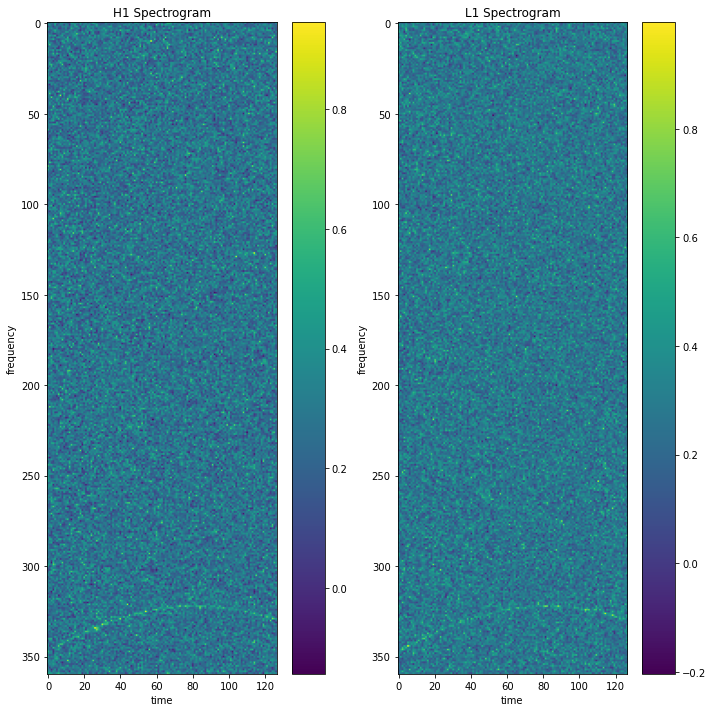

[[[0.333478   0.16771904 0.33968183 ... 0.2701389  0.11857367 0.42117783]
  [0.3077219  0.4580117  0.23059675 ... 0.26939833 0.22861329 0.20825195]
  [0.09215807 0.26027173 0.2768124  ... 0.3088189  0.24497885 0.20788574]
  ...
  [0.2918244  0.26563707 0.02045513 ... 0.08298882 0.18168946 0.30613607]
  [0.3471853  0.41594437 0.14893036 ... 0.41004774 0.32055393 0.07696126]
  [0.50968486 0.45492083 0.46702763 ... 0.3025635  0.39987794 0.31434733]]

 [[0.14879228 0.24176906 0.16885151 ... 0.3067437  0.28305665 0.25290257]
  [0.53874534 0.26520154 0.448552   ... 0.5212836  0.32612035 0.31359863]
  [0.22812207 0.28072575 0.48412102 ... 0.21649577 0.44230142 0.32696396]
  ...
  [0.18771376 0.22980754 0.09281845 ... 0.19269748 0.31088325 0.22592232]
  [0.08739674 0.37726673 0.59807014 ... 0.37397462 0.1677219  0.41383463]
  [0.18384272 0.31174138 0.24057066 ... 0.23074272 0.40112847 0.36488444]]]

/kqi/output/g2net-detecting-continuous-gravitational-waves/test/0040fc1b3.hdf5
img.max(), img.m

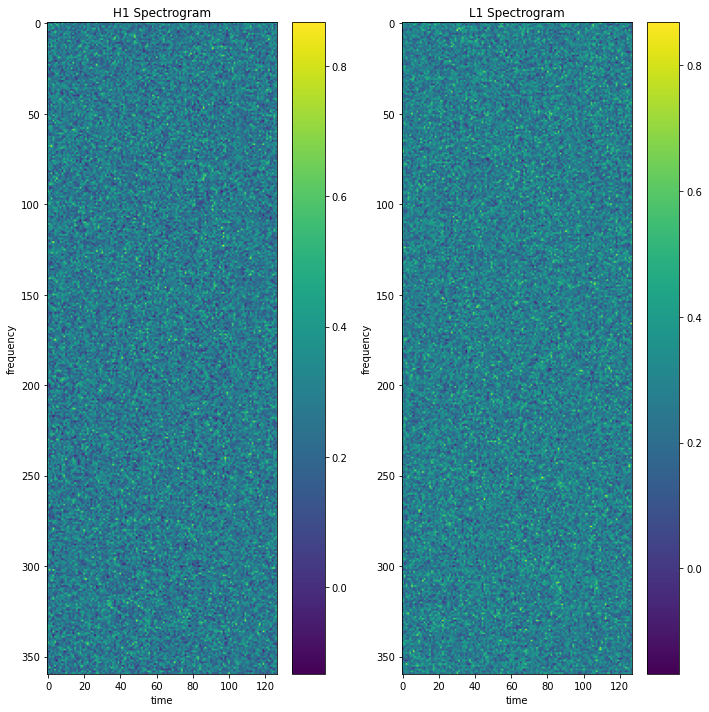

[[[0.10338327 0.3475056  0.05905847 ... 0.2072564  0.3046251  0.49499783]
  [0.4551719  0.34249508 0.5843108  ... 0.5144179  0.02569173 0.2311659 ]
  [0.36244154 0.31157452 0.27231997 ... 0.3931478  0.1391466  0.30000272]
  ...
  [0.21998723 0.06723262 0.29330942 ... 0.17490506 0.03055013 0.32342666]
  [0.37516162 0.3373756  0.32951084 ... 0.49124348 0.3818305  0.259139  ]
  [0.19345333 0.3704908  0.0726738  ... 0.39612088 0.14054362 0.20406629]]

 [[0.4415526  0.37988123 0.188276   ... 0.23219672 0.17461209 0.12418348]
  [0.2998501  0.35537967 0.23220393 ... 0.4058051  0.33074814 0.1808838 ]
  [0.49455112 0.21579129 0.35679448 ... 0.4244195  0.08199056 0.11541884]
  ...
  [0.2378432  0.34084633 0.27664104 ... 0.3665066  0.40416396 0.16940647]
  [0.19542813 0.33460027 0.42099985 ... 0.07736545 0.30686036 0.22603081]
  [0.15087375 0.25919378 0.29174033 ... 0.3341661  0.37113172 0.27097982]]]


In [20]:
print("=> train label dist")
print(train_df.target.value_counts())
print()

print("=> train+test SFTs w")
_df = pd.concat([train_df, test_df])
print("H1 SFTs w max(), min()", _df["H1 SFTs w"].max(), _df["H1 SFTs w"].min())
print("L1 SFTs w max(), min()", _df["L1 SFTs w"].max(), _df["L1 SFTs w"].min())
print()

#normalize_type = "default-norm|p-norm|ts-a"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "spec-sequence_a|ts-ma|p-norm"
#normalize_type = "spec-sequence_a|ts-ma|p-stand"
#normalize_type = "spec-sequence_a|ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-norm"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|p-stand"
#normalize_type = "same_ts_interval|p-common-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel"

#cfg_step = 32
#cfg_step = 64
#cfg_step = 128

#cfg_spec_max = 4096
#cfg_spec_max = 4224


# 画像可視化
print("=> normalize_type:", normalize_type)

_i = 10
_path = train_df.iloc[_i]["path"]
#_path = add_df_all.iloc[_i]["path"]
#if "/work" in os.getcwd():
#    _path = sorted(glob.glob(f"{ADD_DIR_TRAIN}/*.hdf5"))[-1]
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360,
                 )
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", train_df.iloc[_i]["target"])
show_1img_2ch(img)
print(img)

print()
_path = test_df.iloc[_i]["path"]
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/a666b93a9.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d6828b59a.hdf5"
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360)
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", test_df.iloc[806]["target"])
show_1img_2ch(img)
print(img)

In [21]:
#%debug

In [22]:
#=====

# To npy

In [23]:
#!rm -r {NPY_DIR}/{normalize_type}

In [24]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

def hdf5_to_npy(h_paths, out_dir):
    """
    前処理したhdf5データをnpyに保存する
    """
    if cfg_is_npy and (os.path.exists(out_dir) == False): 
        os.makedirs(out_dir, exist_ok=True)
        for _path in tqdm(h_paths):
            img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                              norm_type=normalize_type, 
                              ch=cfg_ch, 
                              freq=360,
                             )
            np.save(os.path.join(out_dir, f'{Path(_path).stem}.npy'), np.array(img))
    else:
        print(f"INFO: Exist {out_dir}")


if cfg_is_npy:
    _npy_dir = f"{NPY_DIR}/{normalize_type}"
    _max_workers = multiprocessing.cpu_count()  # total CPU
    with ThreadPoolExecutor(max_workers=_max_workers, thread_name_prefix="thread") as executor:
        hdf5_to_npy(train_df["path"].to_numpy(), f"{_npy_dir}/train")
        if IS_MAKE_SUB or (PSEUDO_CSV != ""):
            hdf5_to_npy(test_df["path"].to_numpy(), f"{_npy_dir}/test")
        if ADD_DIRS_STR != "":
            for _add_dir in eval(ADD_DIRS_STR):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        if ADD_PSEUDO_DIRS != "":
            for _add_dir in eval(ADD_PSEUDO_DIRS):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        
    # path書き換え
    train_df["path"] = f"{_npy_dir}/train/" + train_df["id"] + ".npy"
    print(train_df["path"].iloc[0])  # パス確認
    if IS_MAKE_SUB:
        test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
        print(test_df["path"].iloc[0])  # パス確認
    if ADD_DIRS_STR != "":
        add_df_all["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_df_all["path"].to_numpy()
        ]
        add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_df_all["path"].iloc[0])  # パス確認
    if PSEUDO_CSV != "":
        pseudo_df["path"] = f"{_npy_dir}/test/" + pseudo_df["id"] + ".npy"
        pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(pseudo_df["path"].iloc[0])  # パス確認
    if ADD_PSEUDO_DIRS != "":
        add_pseudo_df["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_pseudo_df["path"].to_numpy()
        ]
        add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_pseudo_df["path"].iloc[0])  # パス確認

INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/train
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/test
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex003_generating_noise_2_gap
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_1
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso_1
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_noise_gap1400
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_signal_gap800
INFO: Exist /workspace/g2ne

In [25]:
#=====

# Libraries

In [26]:
import warnings
warnings.filterwarnings("ignore")  

import os
import gc
import cv2
import math
import copy
import time
import random
import shutil
import yaml
import glob
from pprint import pprint
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict
import traceback
import imagesize

# For data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
#import plotly.express as px
from PIL import Image
from matplotlib import pyplot as plt

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import torchaudio

# Utils
import pickle, joblib
from tqdm import tqdm
tqdm.pandas()

# Sklearn Imports
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold

# For Image Models
import timm
print("timm:", timm.__version__)
from timm.data import ImageDataset
from timm.data.mixup import Mixup, one_hot
from timm.data.auto_augment import rand_augment_transform
from timm.loss.cross_entropy import SoftTargetCrossEntropy, LabelSmoothingCrossEntropy
from timm.scheduler import CosineLRScheduler  # warmupつきCosineAnnealingLR

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# tta
import ttach as tta

# DDP
# 何故か3090ではエラーになる
#from accelerate import Accelerator, DistributedType, DistributedDataParallelKwargs

## Synchronized-BatchNorm for DP
## https://blog.shikoan.com/sync-batch-norm-pytorch/
#import sys
#sys.path.append('./Synchronized-BatchNorm-PyTorch')
#from sync_batchnorm import convert_model, DataParallelWithCallback 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

TORCH_VERSION = '.'.join(torch.__version__.split('.')[:3])
print('torch:', TORCH_VERSION)

timm: 0.6.12
device: cuda
torch: 1.13.0+cu117


In [27]:
%reload_ext autoreload
%autoreload 2
from src.sam import SAM, ASAM
from src.cv_split import cv_split, cv_split_kfold

In [28]:
## timmのモデル一覧
## https://github.com/rwightman/pytorch-image-models/blob/master/results/README.md
##!pip install "git+https://github.com/rwightman/pytorch-image-models.git"
#import timm
#from pprint import pprint
#model_names = timm.list_models(pretrained=True)
#pprint(model_names)

In [29]:
#def test_timm_lr_Scheduler():
#    """
#    timmのlr_Schedulerの動作確認
#    https://timm.fast.ai/SGDR#cycle_limit=2
#    """
#    from timm import create_model 
#    from timm.optim import create_optimizer
#    from types import SimpleNamespace
#    from matplotlib import pyplot as plt
#
#    def get_lr_per_epoch(scheduler, num_epoch):
#        lr_per_epoch = []
#        for epoch in range(num_epoch):
#            lr_per_epoch.append(scheduler.get_epoch_values(epoch))
#        return lr_per_epoch
#
#    model = create_model('resnet34')
#
#    num_epoch = 50
#    
#    args = SimpleNamespace()
#    args.weight_decay = 0
#    args.lr = 1e-2
#    args.opt = 'adam' 
#    args.momentum = 0.9
#
#    optimizer = create_optimizer(args, model)
#
#    scheduler = CosineLRScheduler(optimizer, 
#                                  t_initial=num_epoch//3,  # 総エポック数
#                                  lr_min=args.lr*1e-2,  # 最小学習率
#                                  warmup_t=3,  # ウォームアップ完了時のエポック数
#                                  warmup_lr_init=args.lr*1e-2,  # ウォームアップの初期学習率
#                                  warmup_prefix=True,  # Warmupが完了したタイミングの学習率をオプティマイザーで設定した基本学習率にするかどうか
#                                  cycle_limit=1,  # lr restartの回数
#                                 )
#    lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)
#
#    plt.plot([i for i in range(num_epoch)], lr_per_epoch);
#    
#test_timm_lr_Scheduler()

# CFG

In [30]:
import os, yaml, shutil

class Config:
    def __init__(self):
        self.name=NAME
        self.train=True
        self.debug=DEBUG
        self.print_freq=1000
        self.is_save_per_steps=False
        self.target_col="target"
        self.num_classes=1
        self.loss = "nn.BCEWithLogitsLoss"
        
        self.model_cls=model_cls
        self.apex=cfg_apex
        self.load_model_path=load_model_path
        #self.load_model_path=f"{OUTPUT_DIR}/tmp_fold0_seed0_best_score.pth"
        #self.is_load_opt=True
        self.is_load_opt=False
        
        # ============== model params ==============
        self.model_name=MODEL_NAME
        self.size_h=size_h
        self.size_w=size_w
        self.batch_size=BATCH_SIZE
        self.gradient_accumulation_steps=gradient_accumulation_steps
        self.is_syncBN = is_syncBN
        self.pretrained = cfg_pretrained
        self.drop_rate = cfg_drop_rate
        self.drop_path_rate = cfg_drop_path_rate
        # ==========================================
        
        self.num_workers=8#16 if "/work" in os.getcwd() else 8
        self.epochs=epochs
        self.optimizer=cfg_optimizer
        self.lr=lr
        self.warmup_lr_init=self.lr*min_lr_ratio
        self.min_lr=self.lr*min_lr_ratio
        self.weight_decay=weight_decay
        self.scheduler=cfg_scheduler  # 'CosineLRScheduler'  # warmup
        self.warmup_t=warmup_t
        self.T_max=epochs
        self.max_grad_norm=1000
        
        self.cv_col=cfg_cv_col
        self.seeds=cfg_seeds
        self.n_fold=n_fold
        self.trn_fold=trn_fold
        
        self.is_wandb=is_wandb
        self.device_ids=device_ids
        
        # ============== data params ==============
        self.step=cfg_step
        self.spec_max=cfg_spec_max
        self.ch=cfg_ch
        self.freq=360
        self.norm_type=normalize_type
        # ==========================================
        
        # 自作mixup
        self.prob_mixup = cfg_prob_mixup  # 0.0なら発生確率=0
        self.mix_alpha = 1.0
        self.is_mix_or = True
        #self.mixup_off_epoch = self.epochs-5  # 最後の5epochはmixup/cutmixなしにする
        self.mixup_off_epoch = 0  # 常にmixup/cutmixなし
        
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        self.prob_sample_mixup = cfg_prob_sample_mixup
        # sample_mixupのデータはpseudoデータだけにするか
        self.is_sample_mixup_use_pseudo = cfg_is_sample_mixup_use_pseudo
        
        # 追加データのtarget=0とオリジナルのtarget=0とのmixup確率
        self.prob_add_sample_nega_mixup = cfg_prob_add_sample_nega_mixup
        
        # データセットの移動平均のpowerとのmixupの確率
        self.prob_mean_mixup = cfg_prob_mean_mixup
        
        # ch追加するか
        self.is_add_ch = cfg_is_add_ch
        
        # スペクトログラムの開始点をランダムに変えるか
        self.prob_spec_start_random = cfg_prob_spec_start_random
        
        # test setのような縦線や横線のノイズ入れる確率
        self.prob_noise_band = cfg_prob_noise_band
        
        # test setのような外れ点ノイズ入れる確率
        self.prob_noise_spot = cfg_prob_noise_spot
        
        # test setのようなまばらな外れ縦線ノイズ入れる確率
        self.prob_noise_vline = cfg_prob_noise_vline
        
        # test setのようなまばらな外れ横バンドノイズ入れる確率
        self.prob_noise_hband = cfg_prob_noise_hband
        
        # target=0のデータのチャネル入れ替える確率
        self.prob_swap_ch_nega = cfg_prob_swap_ch_nega
        
        # target=0のデータhflipする確率
        self.prob_flip_nega = cfg_prob_flip_nega
        
        # target=0のデータ同士をシャッフルする確率
        self.prob_swap_nega = cfg_prob_swap_nega
        
        # target=0のデータをVshiftする確率
        self.prob_vshift_nega = cfg_prob_vshift_nega
        
        # データ関係なくVshiftする確率
        self.prob_vshift = cfg_prob_vshift
        
        # torchaudioで縦横cutout(マスク)する本数
        self.time_mask_num = cfg_time_mask_num  # 縦線
        self.freq_mask_num = cfg_freq_mask_num  # 横線
        self.time_mask_param = cfg_time_mask_param  # マスクの可能な最大長。[0, time_mask_param) 
        self.freq_mask_param = cfg_freq_mask_param  # マスクの可能な最大長。[0, freq_mask_param) 
        
        # zip_datasetをtrainにして学習するか
        self.is_train_zip_dataset = cfg_is_train_zip_dataset
        
        # 生成したデータは別の切り方でfold分けるときに使うKfoldのAPI名(StratifiedKFold, KFoldなど)。""なら別の切り方でfold分けない
        self.add_split_str = cfg_add_split_str
        
        # データをnpyに変換するか
        self.is_npy = cfg_is_npy
        
        # 学習に追加した生成データのディレクトリ名
        self.add_dirs_str = ADD_DIRS_STR
        
        # 学習に追加したtestの疑似ラベルに使うcsv、確信度の閾値、ハードラベルにするか
        self.pseudo_csv = PSEUDO_CSV
        self.pseudo_ths = [cfg_pseudo_max, cfg_pseudo_min]
        self.is_pseudo_hard = cfg_is_pseudo_hard
        
        # 学習に追加したtestの疑似ラベルをリアルデータ/シュミレーションデータだけにするか
        self.pseudo_type = cfg_pseudo_type
        
        # 追加の疑似ラベルのディレクトリ名
        self.add_pseudo_dirs = ADD_PSEUDO_DIRS
        
        # MultiOutputに使う列の要素。freq_min//cfg_freq_div_n の freq_min//N 列をつくる
        self.freq_div_n = cfg_freq_div_n
        

CFG = Config()
        
if CFG.debug:
    #CFG.seeds=[0,1,2]
    CFG.is_wandb=False
    #CFG.is_wandb=True
    CFG.print_freq=10
    CFG.epochs=1
    #CFG.epochs=5
    #CFG.warmup_t=1
    #CFG.mixup_off_epoch=3
    #CFG.epochs=1
    #CFG.mixup_off_epoch=1
    #CFG.epochs=10
    #CFG.trn_fold=[0]
    #CFG.trn_fold=[0,1,2,3,4]
    train_df = cv_split(train_df, 0, 10, cv_col="target")
    train_df = train_df[train_df["fold"] == 0].reset_index(drop=True)
    print("debug train_df.shape:", train_df.shape)
    test_df = test_df.iloc[:30]
    print("debug test_df.shape:", test_df.shape)
    # モデル削除
    !rm -f {OUTPUT_DIR}/*pth
    
with open(OUTPUT_DIR + "/cfg.yaml", "w") as wf:
    yaml.dump(CFG.__dict__, wf)
        
if len(CFG.device_ids) > 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(_) for _ in CFG.device_ids])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    CFG.batch_size = CFG.batch_size*len(CFG.device_ids)
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(CFG.device_ids[0])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    # For descriptive error messages
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    
pprint(CFG.__dict__)

os.environ['CUDA_VISIBLE_DEVICES']: 0
{'T_max': 50,
 'add_dirs_str': '[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, '
                 'EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, '
                 'EX006_SIGNAL800, EX006_SIGNAL_ISO800]',
 'add_pseudo_dirs': '[EX007_NONSTAT_NOISE800]',
 'add_split_str': 'StratifiedKFold',
 'apex': True,
 'batch_size': 64,
 'ch': 2,
 'cv_col': 'target',
 'debug': False,
 'device_ids': [0],
 'drop_path_rate': 0.2,
 'drop_rate': 0.4,
 'epochs': 50,
 'freq': 360,
 'freq_div_n': 50,
 'freq_mask_num': 2,
 'freq_mask_param': 10,
 'gradient_accumulation_steps': 1,
 'is_add_ch': False,
 'is_load_opt': False,
 'is_mix_or': True,
 'is_npy': True,
 'is_pseudo_hard': False,
 'is_sample_mixup_use_pseudo': True,
 'is_save_per_steps': False,
 'is_syncBN': False,
 'is_train_zip_dataset': False,
 'is_wandb': False,
 'load_model_path': 'none',
 'loss': 'nn.BCEWithLogitsLoss',
 'lr': 0.0004,
 'max_grad_norm': 1000,
 'min_lr': 4.000000000000001e-06,
 'mix_alpha': 

# Utils

In [31]:
def init_logger(log_file=OUTPUT_DIR + '/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print('> SEEDING DONE')

# Wandb

In [32]:
if CFG.is_wandb:
    import wandb
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        api_key = user_secrets.get_secret("WANDB")
        wandb.login(key=api_key)
        anonymous = None
    except:
        wandb.login(key="")  # 自分の api key でログイン  # https://wandb.ai/settings
        wandb.init(project="", entity='', name=NAME)
        wandb.config.update(CFG.__dict__)  # ハイパラ登録

# Dataset

In [33]:
class TrainDataset(Dataset):
    def __init__(self, train, transforms=None, 
                 is_npy=True,
                 is_add_ch=False,
                 prob_spec_start_random=0.0,
                 prob_sample_mixup=0.0,
                 is_sample_mixup_use_pseudo=CFG.is_sample_mixup_use_pseudo,
                 prob_add_sample_nega_mixup=0.0,
                 prob_mean_mixup=0.0, 
                 prob_noise_band=0.0,
                 prob_noise_spot=0.0,
                 prob_noise_vline=0.0,
                 prob_noise_hband=0.0,
                 prob_swap_ch_nega=0.0,
                 prob_flip_nega=0.0,
                 prob_swap_nega=0.0,
                 prob_vshift_nega=0.0,
                 prob_vshift=0.0,
                 time_mask_num=0,
                 freq_mask_num=0,
                 time_mask_param=CFG.time_mask_param,
                 freq_mask_param=CFG.freq_mask_param,
                ):
        self.train = train
        self.file_names = train['path'].values
        self.labels = train['target'].values
        self.transforms = transforms
        
        self.labels_freq = train['freq_min//N'].values - (40 // CFG.freq_div_n)  # for MultiOutput
        
        self.orig_flags = train['orig'].values  # np.nanは追加データ
        
        self.is_npy = is_npy  # npyをロードするか
        
        self.prob_spec_start_random = prob_spec_start_random  # スペクトログラムの開始点をランダムに変える確率
        
        self.is_add_ch = is_add_ch  # ch増やすか
        
        #self.train0 = train[train["target"] == 0]   # label=0のdf
        if is_sample_mixup_use_pseudo:
            #self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
            self.train0 = pseudo_df[pseudo_df["target"] < 0.5]   # label=0のdf pseudoのデータだけでmix
            if ADD_PSEUDO_DIRS != "":
                self.train0 = pd.concat([self.train0, add_pseudo_df], ignore_index=True)
        else:
            self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
        
        self.train0_orig = train[train["target"] < 0.5].dropna(subset=['freq min']).reset_index(drop=True)  # label=0かつオリジナルデータのdf
        
        self.prob_sample_mixup = prob_sample_mixup  # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        
        self.prob_add_sample_nega_mixup = prob_add_sample_nega_mixup  # 追加データのtarget=0とオリジナルのtarget=0とをmixup確率
        
        self.prob_mean_mixup = prob_mean_mixup  # データセットの移動平均のpowerとのmixup
        
        self.prob_noise_band = prob_noise_band  # test setのような縦線や横線のノイズ入れる確率
        
        self.prob_noise_spot = prob_noise_spot  # test setのような外れ点ノイズ入れる確率
        
        self.prob_noise_vline = prob_noise_vline  # test setのようなまばらな外れ縦線ノイズ入れる確率
        
        self.prob_noise_hband = prob_noise_hband  # test setのようなまばらな外れ横バンドノイズ入れる確率
        
        self.prob_swap_ch_nega = prob_swap_ch_nega # negaサンプルch入れ替える確率
        
        self.prob_flip_nega = prob_flip_nega  # negaサンプルhflipする確率
        
        self.prob_swap_nega = prob_swap_nega  # negaサンプル別の使う確率
        
        self.prob_vshift_nega = prob_vshift_nega  # negaサンプルのみ縦方向に平行移動(VShift)する確率
        
        self.prob_vshift = prob_vshift  # 縦方向に平行移動(VShift)する確率
        
        self.time_mask_num = time_mask_num # number of time masking
        self.freq_mask_num = freq_mask_num # number of frequency masking
        self.transforms_time_mask = nn.Sequential(
            # time_mask_param はマスクする幅の最大長。[0, time_mask_param) 
            torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param),
        )
        self.transforms_freq_mask = nn.Sequential(
            # freq_mask_param はマスクする幅の最大長。[0, freq_mask_param) 
            torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param),
        )    
        
    def __len__(self):
        return len(self.train)
    
    def load_img(self, path):
        if self.is_npy:
            img = np.load(path)
        else:
            img = hdf5_to_img(path, CFG.step, CFG.spec_max, 
                              norm_type=CFG.norm_type, 
                              ch=CFG.ch, 
                              freq=CFG.freq)  # (C,H,W)
        img = img.transpose(1, 2, 0)  # (H,W,C)
    
        ### 振幅の開始点をランダムに変更
        if (np.random.rand() > 1 - self.prob_spec_start_random) and (img.shape[1] > CFG.size_w):
            spec_start = img.shape[1] - CFG.size_w
            spec_start = int(np.random.uniform(low=0, high=spec_start))
            img = img[:, spec_start:spec_start+CFG.size_w, :]  # shape=(360, size_w, 2)
            #print("spec_start:", spec_start)
        
        ### 横幅のサイズはsize_wまでにする
        if CFG.size_w > 0:
            img = img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
        
        #print("img.shape:", img.shape)
        return img
    
    def __getitem__(self, index):
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.float)
        img = self.load_img(self.file_names[index])
        
        orig_flag = self.orig_flags[index]
        
        # ===============================================
        # for MultiOutput
        # ===============================================
        label_freq = self.labels_freq[index]
        label_freq = torch.tensor(label_freq, dtype=torch.long)
        label_freq = one_hot(label_freq, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, device='cpu')
        
        # ===============================================
        # test setのような縦線や横線のノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 v_noise_band {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 v_noise_band {v_n_line}")
            
        # ===============================================
        # test setのような外れ点ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_spot:
            # H1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 0] *= _ratio  # 係数掛ける
            #print(f"{index} H1 noise_spot {n_area}")
        if np.random.rand() > 1 - self.prob_noise_spot:
            # L1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 1] *= _ratio  # 係数掛ける
            #print(f"{index} L1 noise_spot {n_area}")
            
        # ===============================================
        # test setのようなまばらな外れ縦線ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_vline:
            # H1の外れ縦線
            v_n_line = np.random.randint(1,8)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 0] += _gs_n
            #print(f"{index} H1 noise_vline {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_vline:
            # L1の外れ縦線
            v_n_line = np.random.randint(1, 5)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,1].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 1] += _gs_n
            #print(f"{index} L1 noise_vline {v_n_line}")
            
        # ===============================================
        # test setのようなまばらな外れ横バンドノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_hband:
            # H1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 0] += _gs_n
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_hband:
            # L1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 1] += _gs_n
            #print(f"{index} L1 h_noise_band {w_n_line}")
            
        # ソフトラベルの対策。negativeとみなすラベルの値
        nega_th = 0.5
        
        # ===============================================
        # VShift
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        if (np.random.rand() > 1 - self.prob_vshift):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift")
        ### Negative VShift
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_vshift_nega):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift_nega")
        
        # ===============================================
        # Negative Swap CH
        # ===============================================
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_swap_ch_nega):
            i0 = img[:,:,0].copy()
            img[:,:,0] = img[:,:,1]
            img[:,:,1] = i0
            #print("swap_ch_nega")
        
        # ===============================================
        # 前回コンペ8位のaug
        # https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/discussion/275335
        # ===============================================
        # LIGO Swap は A.ChannelShuffle で実行
        
        # Negative Flip
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[:, ::-1, :].copy()  # hflip
            #print("hflip_nega")
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[::-1, :, :].copy()  # vflip
            #print("vflip_nega")
        
        # Swap with Other Negative
        if (label < nega_th) and (self.prob_swap_nega > 0.0):
            sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,0] = sample_img[:,:,0]
                #print("h1 swap_nega")
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,1] = sample_img[:,:,1]
                #print("l1 swap_nega")
            
        # ===============================================
        # Sample Mixup
        # ===============================================
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmix
        if np.random.rand() > 1 - self.prob_sample_mixup:
            if label < nega_th:
                sample = self.train.sample()
            else:
                sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            img = (img + sample_img) / 2.0
            # mix_sample_lam の割合で混ぜる
            #mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            #img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
            
            if sample.iloc[0]['target'] >= nega_th:
                label = torch.tensor(sample.iloc[0]['target']).float()
            
            # for MultiOutput
            sample_label_freq = sample.iloc[0]['freq_min//N'] - (40 // CFG.freq_div_n)
            sample_label_freq = torch.tensor(sample_label_freq, dtype=torch.long)
            sample_label_freq = one_hot(sample_label_freq, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, device='cpu')
            label_freq = (label_freq + sample_label_freq) / 2.0
            
            #print("sample_mixup", sample.iloc[0]['target'])
            
        # ===============================================
        # Add Data Nega Sample Mixup
        # ===============================================
        # target=0について add_data と orig_data をmixup
        if np.random.rand() > 1 - self.prob_add_sample_nega_mixup:
            if np.isnan(orig_flag):
                # orig_flagがnegaならadd_data
                if label < nega_th:
                    sample = self.train0_orig.sample()
                sample_img = self.load_img(sample.iloc[0]['path'])
                # mix_sample_lam の割合で混ぜる
                mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
                img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
                #print("add_sample_nega_mixup")
        
        # ===============================================
        # Mean Mixup
        # ===============================================
        # データセット全体の移動平均とmix
        if np.random.rand() > 1 - self.prob_mean_mixup:

            # データセット全体の移動平均の振幅をパワーに変換
            abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step), dtype=np.float32)
            if ("ts-ma" in CFG.norm_type) and (cfg_step % 64 == 0):
                # step%64=0の移動平均は1要素減る
                abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step-1), dtype=np.float32)
            abs_mean_img[0] = amp2power(a_abs_mean_h1, "H1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img[1] = amp2power(a_abs_mean_l1, "L1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img = abs_mean_img.transpose(1, 2, 0)  # (H,W,C)
            # 横幅のサイズはsize_wまでにする
            if CFG.size_w > 0:
                abs_mean_img = abs_mean_img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
            
            # mean_lam の割合で混ぜる
            mean_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            img = mean_lam*img + (1-mean_lam)*abs_mean_img
        
            # 移動平均と混ぜた分のラベルもmix
            if label < nega_th:
                label += 0.1*(1-mean_lam)
            #print("mean_mixup")
            
        # ===============================================
        # ch増やす
        # ===============================================
        if self.is_add_ch:
            img = np.stack([img[:,:,0], img[:,:,1],
                            img[:,:,0] + img[:,:,1], 
                            img[:,:,0] - img[:,:,1]])  # (C,H,W)
            img = img.transpose(1, 2, 0)  # (H,W,C)
              
        if self.transforms:
            img = self.transforms(image=img)["image"]  # (C,H,W)

        # ===============================================
        # Torchaudio Masking
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        # imgはtorch型の(C,H,W)形式じゃないとだめ
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.time_mask_num): # time masking
                img = self.transforms_time_mask(img)
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.freq_mask_num): # frequency masking
                img = self.transforms_freq_mask(img)
            
        return img, label, label_freq

# Transform

In [34]:
def get_transforms(*, data):
    if data == 'train':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            #A.ChannelShuffle(always_apply=False, p=0.5),
            #A.GridDropout(ratio=0.5, holes_number_x=4, holes_number_y=8, random_offset=True, p=0.5),
            #A.VerticalFlip(p=0.5),
            #A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=(0, 0.2), rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_WRAP),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            ToTensorV2(),
        ])
    #elif data == 'tta1':
    #    return A.Compose([
    #        A.Resize(CFG.size_h, CFG.size_w),
    #        A.ChannelShuffle(always_apply=True, p=1.0),
    #        ToTensorV2(),
    #    ])

In [35]:
def mixup(x, y, alpha):
    """
    Usage:
        x, y = batch["x"], batch["y"]
        x, y_mixs = mixup(x, y.long(), 1.0)
        y_hat = model(x.float())
        loss = criterion(y_hat, y_mixs[0], mix_decision) * y_mixs[2] + criterion(y_hat, y_mixs[1], mix_decision) * (1.0 - y_mixs[2])
    """
    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.7)
    x = lam*x + (1-lam)*shuffled_x
    ys = (y, shuffled_y, lam)

    return x, ys

# Dataloader check

torch.Size([15, 2, 360, 127]) torch.Size([15]) torch.Size([15, 1, 11])


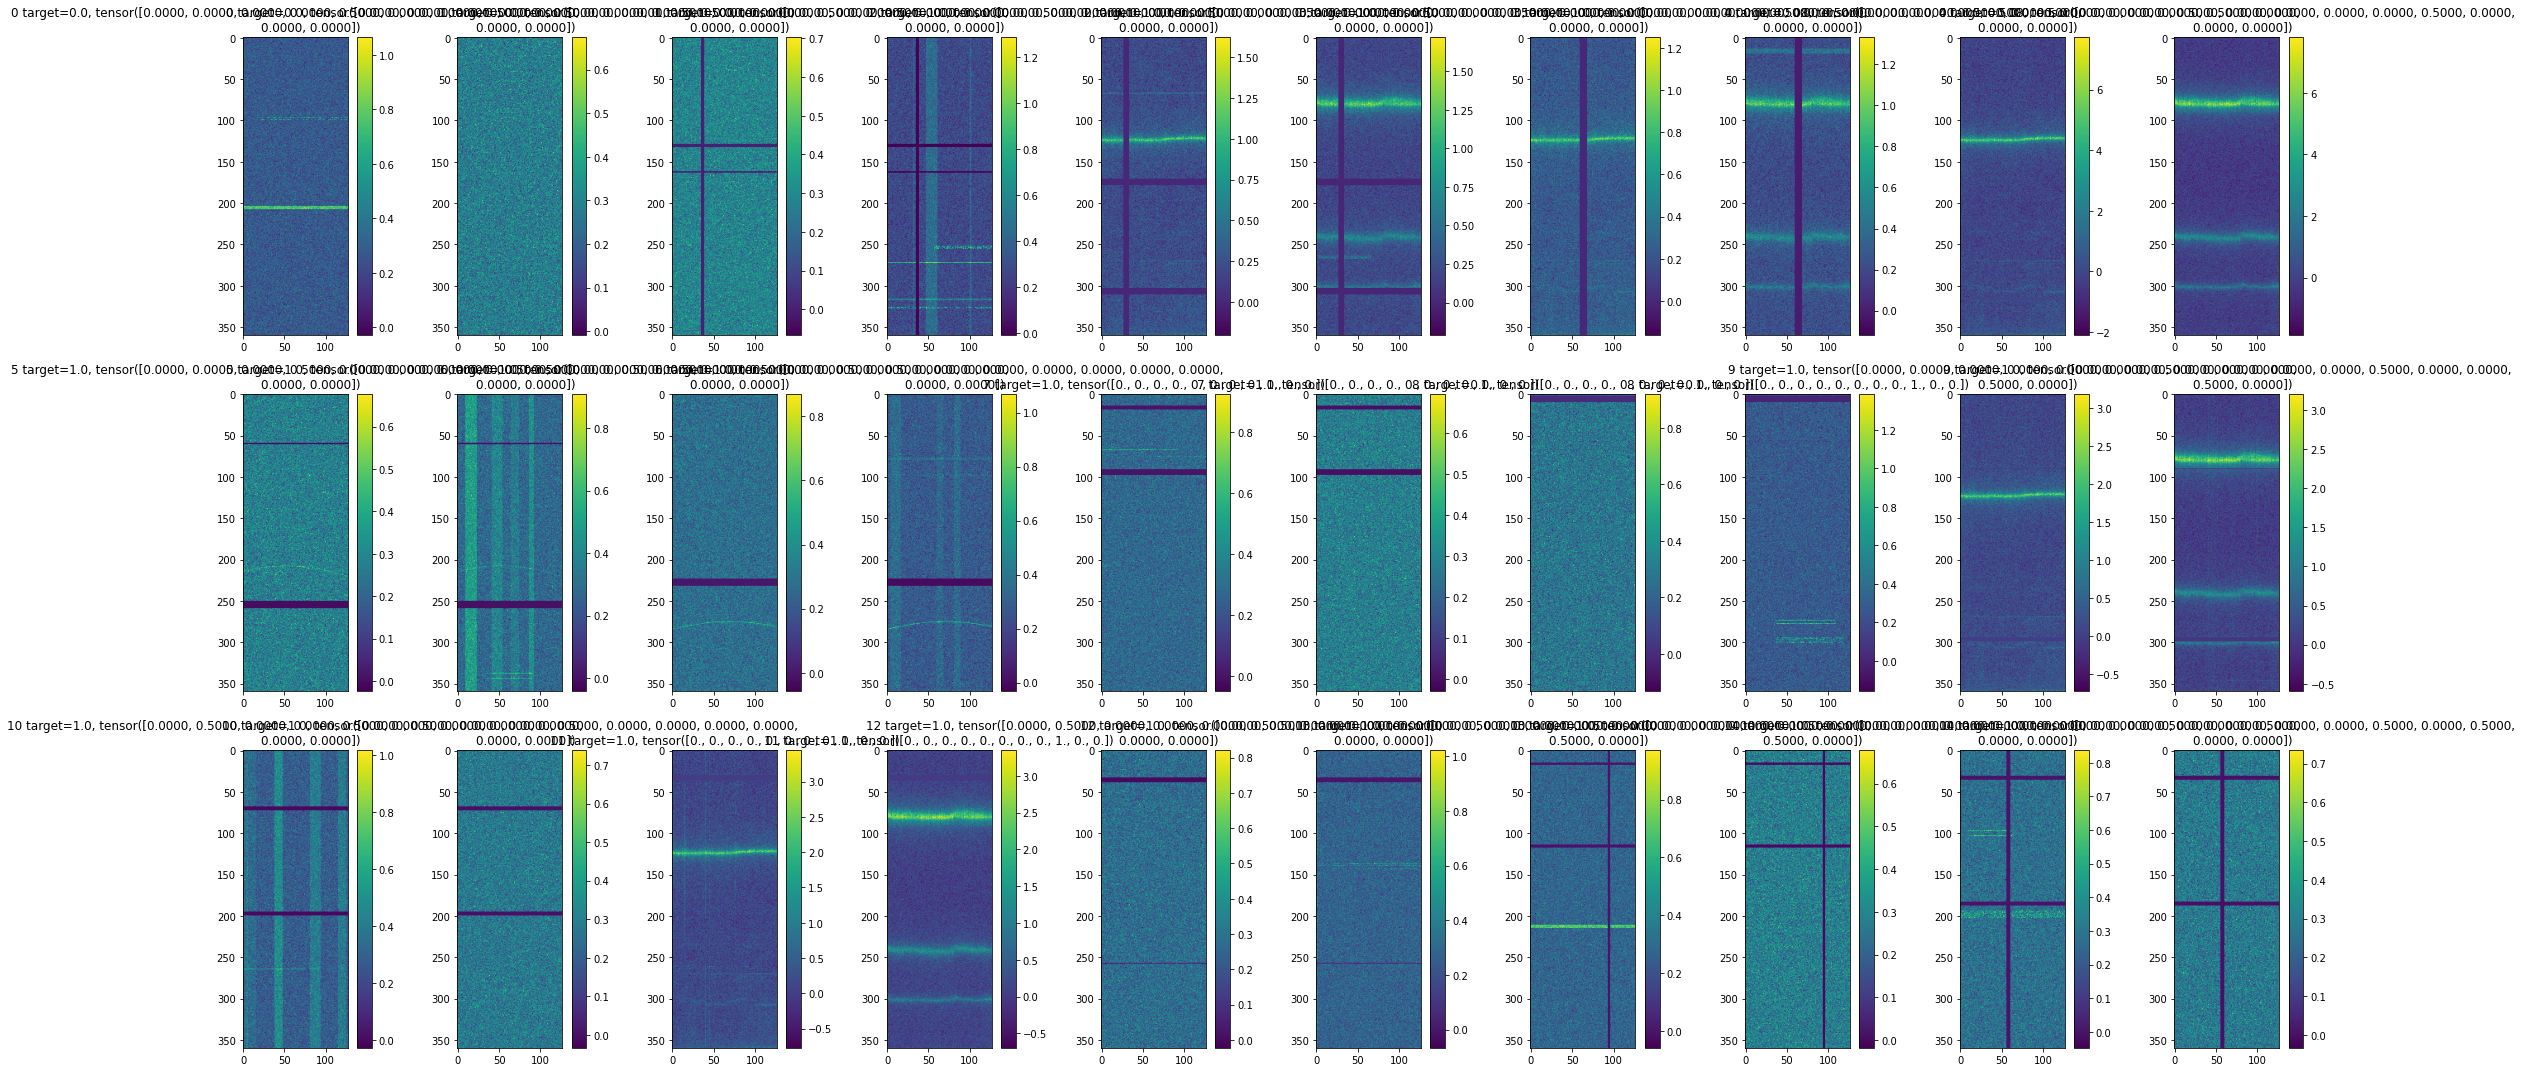

In [36]:
#%%time
# timeでファイルioに時間かかるか確認
if CFG.is_train_zip_dataset:
    train_dataset = ZipDataset(
        path=f"{zip_path}/archive", mod=zip_mod, transforms=get_transforms(data="train")
    )
else:
    train_dataset = TrainDataset(
        train_df,
        #pd.concat([train_df, add_df_all]),
        transforms=get_transforms(data="train"),
        is_npy=CFG.is_npy,
        is_add_ch=CFG.is_add_ch,
        prob_spec_start_random=CFG.prob_spec_start_random,
        prob_sample_mixup=CFG.prob_sample_mixup,
        prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
        prob_mean_mixup=CFG.prob_mean_mixup,
        prob_noise_band=CFG.prob_noise_band,
        prob_noise_spot=CFG.prob_noise_spot,
        prob_noise_vline=CFG.prob_noise_vline,
        prob_noise_hband=CFG.prob_noise_hband,
        prob_swap_ch_nega=CFG.prob_swap_ch_nega,
        prob_flip_nega=CFG.prob_flip_nega,
        prob_swap_nega=CFG.prob_swap_nega,
        prob_vshift_nega=CFG.prob_vshift_nega,
        prob_vshift=CFG.prob_vshift,
        time_mask_num=CFG.time_mask_num,
        freq_mask_num=CFG.freq_mask_num,
    )
    #train_dataset = TrainDataset(
    #    #train_df,
    #    pd.concat([train_df, add_df_all]),
    #    transforms=get_transforms(data="train"),
    #    is_npy=CFG.is_npy,
    #    #is_add_ch=True,
    #    #prob_spec_start_random=1.0,
    #    prob_add_sample_nega_mixup=1.0,
    #    prob_sample_mixup=1.0,
    #    prob_mean_mixup=1.0,
    #    prob_noise_band=1.0,
    #    prob_noise_spot=1.0,
    #    prob_noise_vline=1.0,
    #    prob_noise_hband=1.0,
    #    #prob_swap_ch_nega=1.0,
    #    #prob_flip_nega=1.0,
    #    #prob_swap_nega=1.0,
    #    #prob_vshift_nega=1.0,
    #    #prob_vshift=1.0,
    #    #time_mask_num=5,
    #    #freq_mask_num=5,
    #)
train_loader = DataLoader(
    train_dataset,
    batch_size=15,
    shuffle=True,
    num_workers=0, pin_memory=True, drop_last=True,
    #collate_fn=mixup_collate_fn,
)
for step, (images, labels, labels_freq) in enumerate(train_loader):
    print(images.shape, labels.shape, labels_freq.shape)
    
    if normalize_type == "largekernel":
        plt.figure(figsize=(30,25))
    else:
        plt.figure(figsize=(30,15))
    i = 1
    for idx, (im, la, la_f) in enumerate(zip(images, labels, labels_freq)):
        #print(la_f.shape)
        #print(la_f.squeeze().shape)
        im = im.transpose(0, 1).transpose(1, 2)  # (H,W,C)
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,0])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,1])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if i > 30:
            break
            
    plt.tight_layout()
    plt.show()
    break

In [37]:
#%debug

In [38]:
#=====

# Model

In [39]:
class CustomModel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch)        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModel(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [40]:
# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook を参考にdropout入れて過学習避ける
class CustomModelDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch, 
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [41]:
class CustomModelMultiOutput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // CFG.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

#print(CFG.model_name)
#m = CustomModelMultiOutput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o1, o2 = m(x.cuda())
#print(o1, o1.shape)
#print(o2, o2.shape)
##m

In [42]:
#=====

In [43]:
class CustomModelAddEmb(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features+(500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, CFG.num_classes)  # embを1次元増やす
        )
    def forward(self, x, add_x):
        feat = self.net(x)
        #print(feat.shape, add_x.shape)
        y = self.head( torch.cat((feat, add_x), 1) )
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelAddEmb(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#add_x = torch.rand(CFG.batch_size, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)
#o = m(x.cuda(), add_x.cuda())
#print(o, o.shape)
##m

In [44]:
#=====

In [45]:
class CustomModelMultiInput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net1 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2) 
        self.net2 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2)
        self.head = nn.Sequential(
            nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net1.num_features + self.net2.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        
        x1 = x[:, :CFG.ch//2, :, :]
        x2 = x[:, CFG.ch//2:, :, :]
        #print(x1.shape, x2.shape)
        
        feat1 = self.net1(x1)
        feat2 = self.net2(x2)
        y = self.head( torch.cat((feat1, feat2), 1) )
        #print(feat1.shape, feat2.shape, y.shape)
        
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelMultiInput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [46]:
#=====

In [47]:
class CustomModelLargeKernel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        if pretrained:
            pth = "/volume/kaggle/g2net2/kaggle_dl/g2net-detecting-continuous-gravitational-waves-v0/model_best.pth"
        else:
            pth = ""
        self.net = largekernel.get_model(
            model_name="tf_efficientnetv2_b0",
            path=pth,
            conv_in_chans=32
        )
        self.net.classifier = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelLargeKernel().cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [48]:
#=====

In [49]:
# https://github.com/sinpcw/kaggle-whale2/blob/master/models.py
def loadpth(pth: str, map_location=None) -> OrderedDict:
    """
    パラメータロードのヘルパー関数.
    DataParallel化したモデルは module.xxxx という形式で保存されるため読込み時にmodule.から始まる場合はそれを取除く.
    """
    ostate = torch.load(pth, map_location=map_location)['model']
    nstate = OrderedDict()
    for k, v in ostate.items():
        if k.startswith('module.'):
            nstate[k[len('module.'):]] = v
        else:
            nstate[k] = v
    return nstate

# Metric

In [50]:
def get_score(labels: np.ndarray, predictions: np.ndarray):
    # predictions が nan になったときの対策
    try:
        return roc_auc_score(labels, predictions)
    except:
        return 0.0

# Helper

In [51]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [52]:
def forward_step(step, losses, batch_size, model, criterion, images, labels, prob_mixup, optimizer, scaler, optimizer_step,
                 labels_freq, criterion2):  # for MultiOutput
    """
    SAMは2回forward必要だからforwardの処理（loss計算+backward）切り出す
    """
    # SAM 1st/2nd Path
    optimizer.step = optimizer_step
    
    # ===========================================
    # model forward for mixup
    # ===========================================
    if np.random.rand() > 1 - prob_mixup:
        x, y_mixs = mixup(images, labels.long(), CFG.mix_alpha)  # y_mixs=(target, shuffled_target, lambda)
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(x.float())  # for MultiOutput
                if CFG.is_mix_or:
                    y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                    loss = criterion(outputs, y_mix_or.float())
                else:
                    loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
        else:
            outputs, outputs2 = model(x.float())  # for MultiOutput
            if CFG.is_mix_or:
                y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                loss = criterion(outputs, y_mix_or.float())
            else:
                loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
    else:
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
                loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
        else:
            outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
            loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
            
    loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
    loss = (loss + loss2) / 2.0  # for MultiOutput
    
    # ===========================================
    # record loss
    # ===========================================
    losses.update(loss.item(), batch_size)  # loggerにloss保存
    if CFG.gradient_accumulation_steps > 1:
        loss = loss / CFG.gradient_accumulation_steps  # normalize loss to account for batch accumulation
    if CFG.apex:
        scaler.scale(loss).backward()  # 各パラメータの勾配を算出
    else:
        loss.backward()  # 誤差逆伝播して各パラメータの勾配を算出
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)  # 勾配クリッピング
    
    # ===========================================
    # optimizer step
    # ===========================================
    if (step + 1) % CFG.gradient_accumulation_steps == 0:
        if CFG.apex:
            scaler.step(optimizer)  # 勾配の情報を用いたパラメータの更新
            scaler.update()
        else:
            optimizer.step()  # 勾配の情報を用いたパラメータの更新
        optimizer.zero_grad()  # 勾配情報の初期化
        
    return optimizer, scaler, losses, grad_norm

In [53]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, 
             prob_mixup=False, mixup_fn=None,
             criterion2=None):  # for MultiOutput
    model.train()
    if CFG.apex:
        scaler = GradScaler()
    else:
        scaler = None
    losses = AverageMeter()
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        ## ===========================================
        ## timm mixup/cutmix
        ## ===========================================
        #if mixup_fn is not None:
        #    images, labels = mixup_fn(images, labels)
        #else:
        #    labels = one_hot(labels, CFG.num_classes, device=device)
        
        if isinstance(optimizer, SAM) or isinstance(optimizer, ASAM):
            optimizer, scaler, _, _ = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                   prob_mixup, optimizer, scaler, 
                                                   optimizer.first_step,
                                                   labels_freq, criterion2)  # for MultiOutput
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.second_step,
                                                                labels_freq, criterion2)  # for MultiOutput
        else:
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.step,
                                                                labels_freq, criterion2)  # for MultiOutput
            
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.4e}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=optimizer.param_groups[0]["lr"]))
        
        if CFG.is_save_per_steps:
            torch.save(
                {
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict(),
                },
                OUTPUT_DIR + "/per_steps.pth",
            )

    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg

In [54]:
@torch.inference_mode()  # pytorch >= 1.9
def valid_fn(valid_loader, model, criterion, device, 
             criterion2):  # for MultiOutput
    model.eval()
    losses = AverageMeter()
    preds = []
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(valid_loader):  # for MultiOutput
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        # ===========================================
        # compute loss
        # ===========================================
        with torch.no_grad():
            # for MultiOutput
            outputs, outputs2 = model(images)  # logit
        loss = criterion(outputs, labels)
        loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
        loss = (loss + loss2) / 2.0  # for MultiOutput
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        ## ===========================================
        ## record topk index
        ## ===========================================
        #_, tk = torch.topk(outputs, 5, dim=1)
        #topk_indexs = tk.to('cpu').detach().numpy()
        #preds.append(topk_indexs[:,0])  # top1
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
        
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
            
    predictions = np.concatenate(preds)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg, predictions

# Train loop

In [55]:
def train_loop(folds, fold, seed):
    
    LOGGER.info(f"========== fold: {fold}, seed: {seed} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values
    
    if CFG.is_train_zip_dataset:
        train_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod, transforms=get_transforms(data='train'))
        valid_dataset = TrainDataset(valid_folds, is_npy=False, transforms=get_transforms(data='valid'))
    else:
        
        train_dataset = TrainDataset(train_folds, 
                                     transforms=get_transforms(data='train'), 
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                     prob_spec_start_random=CFG.prob_spec_start_random,
                                     prob_sample_mixup=CFG.prob_sample_mixup,
                                     prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
                                     prob_mean_mixup=CFG.prob_mean_mixup,
                                     prob_noise_band=CFG.prob_noise_band,
                                     prob_noise_spot=CFG.prob_noise_spot,
                                     prob_noise_vline=CFG.prob_noise_vline,
                                     prob_noise_hband=CFG.prob_noise_hband,
                                     prob_swap_ch_nega=CFG.prob_swap_ch_nega,
                                     prob_flip_nega=CFG.prob_flip_nega,
                                     prob_swap_nega=CFG.prob_swap_nega,
                                     prob_vshift_nega=CFG.prob_vshift_nega,
                                     prob_vshift=CFG.prob_vshift,
                                     time_mask_num=CFG.time_mask_num,
                                     freq_mask_num=CFG.freq_mask_num,
                                    )
        valid_dataset = TrainDataset(valid_folds, 
                                     transforms=get_transforms(data='valid'),
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                    )
    
    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineLRScheduler':
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True)
        elif CFG.scheduler=='CosineLRScheduler_cycle_limit3':
            _cycle_limit = 3
            # https://timm.fast.ai/SGDR#cycle_limit=2
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs//_cycle_limit, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True,
                                          cycle_limit=_cycle_limit,
                                         )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = eval(CFG.model_cls)(pretrained=CFG.pretrained)
    
    if os.path.exists(CFG.load_model_path):
        LOGGER.info("=> loading checkpoint '{}'".format(CFG.load_model_path))
        states = torch.load(CFG.load_model_path, map_location=torch.device("cpu"))
        if len(CFG.device_ids) > 1:
            model.load_state_dict( loadpth(CFG.load_model_path, map_location=torch.device("cpu")) )
        else:
            model.load_state_dict(states["model"])
    
    if len(CFG.device_ids) > 1:
        if CFG.is_syncBN:
            # https://blog.shikoan.com/sync-batch-norm-pytorch/
            model = convert_model(model).to(device) # Batch NormをSync Batch Normに変換
            model = DataParallelWithCallback(model, device_ids=CFG.device_ids) # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids} use SyncBN")
        else:
            model.to(device)
            model = nn.DataParallel(model, device_ids=CFG.device_ids)  # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids}")
        # https://aru47.hatenablog.com/entry/2020/11/06/225052
        cudnn.benchmark = True
    else:
        model.to(device)

    if CFG.optimizer == "adam":
        optimizer = Adam(model.parameters(), lr=CFG.lr, amsgrad=False, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == "adamw":
        optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'nesterov':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay, nesterov=True)
    elif CFG.optimizer == 'sam':
        optimizer = SAM(model.parameters(), torch.optim.AdamW, lr=CFG.lr, weight_decay=CFG.weight_decay, rho=0.05)
        
    scheduler = get_scheduler(optimizer)
    
    if os.path.exists(CFG.load_model_path):
        if CFG.is_load_opt:
            LOGGER.info("=> loading optimizer and scheduler")
            optimizer.load_state_dict(states["optimizer"])
            scheduler.load_state_dict(states["scheduler"])

    if CFG.is_wandb:
        # wandbでpytorchのモデル監視
        wandb.watch(model)
            
    # ====================================================
    # loop
    # ====================================================
    train_criterion = eval(CFG.loss)().to(device)
    valid_criterion = eval(CFG.loss)().to(device)
    # for MultiOutput
    train_criterion2 = nn.CrossEntropyLoss().to(device)
    valid_criterion2 = nn.CrossEntropyLoss().to(device)
    
    best_score = -np.inf
    best_loss = np.inf
    
    #mixup_fn = Mixup(**CFG.mixup_args)
    mixup_fn = None
    prob_mixup = CFG.prob_mixup
    
    for epoch in range(CFG.epochs):
        
        # mixup_off_epoch以上はmixup/cutmixなしにする
        if epoch >= CFG.mixup_off_epoch:
            mixup_fn = None
            prob_mixup = 0.0
            #LOGGER.info(f'Epoch {epoch+1} - mixup_fn=None')
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, train_criterion, optimizer, epoch, scheduler, device, 
                            prob_mixup=prob_mixup,
                            criterion2=train_criterion2)  # for MultiOutput

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, valid_criterion, device,
                                       valid_criterion2)  # for MultiOutput
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        elif isinstance(scheduler, CosineLRScheduler):
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler.step(epoch+1)
            
        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        LOGGER.info(f'Epoch {epoch+1} - lr: {optimizer.param_groups[0]["lr"]:.4e}')
       
        if CFG.is_wandb:
            # save log wandb
            wandb.log({f"[fold{fold}] epoch": epoch+1,
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score,
                       f"[fold{fold}] lr": optimizer.param_groups[0]["lr"]})
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
            
    valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth', map_location=torch.device('cpu'))['preds'].tolist()
    #valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth', map_location=torch.device('cpu'))['preds'].tolist()

    return valid_folds

# Main

In [56]:
def get_result(result_df, preds_col="preds", add_info=""):
    labels = result_df[CFG.target_col].values
    preds = result_df[preds_col].values
    preds = np.array([np.array(p) for p in preds])
    score = get_score(labels, preds)
    LOGGER.info(f'{add_info}Score: {score:<.4f}')
    return score
    

def main(df):
    if CFG.train:
        oof_scores = []
        for seed in CFG.seeds:
            seed_torch(seed)
            
            # 生成データロード
            if ADD_DIRS_STR != "":
                add_df = pd.read_csv(f"{OUTPUT_DIR}/add_data.csv")
                if CFG.debug:
                    add_df = cv_split_kfold(add_df, 0, 10)
                    add_df = add_df[add_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_df.shape: {str(add_df.shape)}")

                # cv_split
                if CFG.add_split_str == "":
                    folds = pd.concat([df, add_df], ignore_index=True)
                    folds = cv_split(folds, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                else:
                    # オリジナルデータと生成データは別の切り方でfold分ける
                    if CFG.add_split_str == "KFold":
                        add_df = cv_split_kfold(add_df, seed, CFG.n_fold)
                    else:
                        add_df = cv_split(add_df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold

                    folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                    folds = pd.concat([folds, add_df], ignore_index=True) 
                    
                # 生成データのtarget=1はすべてtrainに使う
                if IS_ADD_ALL_TRAIN1:
                    _orig_folds = folds.dropna(subset=['freq_min//10_target'])
                    _add_folds = folds.dropna(subset=['type'])
                    _add_target0 = _add_folds[_add_folds[CFG.target_col] == 0]
                    _add_target1 = _add_folds[_add_folds[CFG.target_col] == 1]
                    _add_target1["fold"] = -1    
                    folds = pd.concat([_orig_folds, _add_target0, _add_target1]).reset_index(drop=True)
                    print(folds.groupby(['fold', CFG.target_col]).size())

            else:
                folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                
            # zip_df.csvでfinetuneする場合
            if CFG.is_train_zip_dataset:
                folds = pd.read_csv(f'{zip_path}/zip_df.csv')                
                df["fold"] = 0
                folds = pd.concat([folds, df], ignore_index=True)
                
            # 疑似ラベル全foldのtrainに入れる
            if PSEUDO_CSV != "":
                pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/pseudo_df.csv")
                if CFG.debug:
                    pseudo_df = cv_split_kfold(pseudo_df, 0, 30)
                    pseudo_df = pseudo_df[pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"pseudo_df.shape: {str(pseudo_df.shape)}")
                pseudo_df["fold"] = -1
                folds = pd.concat([folds, pseudo_df], ignore_index=True)
            if ADD_PSEUDO_DIRS != "":
                add_pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv")
                if CFG.debug:
                    add_pseudo_df = cv_split_kfold(add_pseudo_df, 0, 30)
                    add_pseudo_df = add_pseudo_df[add_pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_pseudo_df.shape: {str(add_pseudo_df.shape)}")
                add_pseudo_df["fold"] = -1
                folds = pd.concat([folds, add_pseudo_df], ignore_index=True)
                
            folds.to_csv(OUTPUT_DIR +f"/folds_seed{seed}.csv", index=False)
            LOGGER.info(f"folds.shape: {str(folds.shape)}")
            
            # train fold
            scores = []
            oof_df = pd.DataFrame()
            for fold in range(CFG.n_fold):
                if fold in CFG.trn_fold:
                    _oof_df = train_loop(folds, fold, seed)
                    oof_df = pd.concat([oof_df, _oof_df])
                    LOGGER.info(f"========== fold: {fold} seed: {seed} result ==========")
                    _score = get_result(_oof_df, add_info=f"fold{fold} ")
                    scores.append(_score)
                    
                    gc.collect()
                    torch.cuda.empty_cache()
                    
            # CV result
            LOGGER.info(f"========== CV ==========")
            LOGGER.info(f'macro mean folds Score ± std: {np.mean(scores):<.4f} ± {np.std(scores):<.4f}')
            oof_score = get_result(oof_df, add_info=f"oof ")
            oof_scores.append(oof_score)
            # save result
            oof_df.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}.csv', index=False)
            
            if CFG.is_wandb:
                # save log wandb
                wandb.log({f"[fold{str(CFG.trn_fold)}] best_score": oof_score})
            
            plt.hist(oof_df["preds"], bins=100)
            plt.show()
            plt.clf()  # メモリ解放
            plt.close()
            
        if len(oof_scores) > 1:
            LOGGER.info(f'seed macro mean oof Score ± std: {np.mean(oof_scores):<.4f} ± {np.std(oof_scores):<.4f}') 

In [57]:
=====

SyntaxError: invalid syntax (1414413079.py, line 1)

In [ ]:
#if __name__ == '__main__':
#    main(train_df)
#
#if CFG.epochs > 100:
#    from IPython.display import clear_output  # セルの出力削除（1000epもログあると重すぎるので消す）
#    clear_output()

In [ ]:
#%debug

In [ ]:
#=====

# Predict and submit

In [108]:
def _tta(img, ops):
    # input: NxCxHxW
    if ops == 0:
        pass
    elif ops == 1:
        img = torch.flip(img, [-1])
    elif ops == 2:
        img = torch.flip(img, [-2])
    elif ops == 3:
        img = torch.flip(img, [-1, -2])
    elif ops == 4:
        img = torch.rot90(img, 1, [2, 3])
    elif ops == 5:
        img = torch.rot90(img, 3, [2, 3])
    else:
        pass
    return img

In [109]:
@torch.inference_mode()  # pytorch >= 1.9
def inference(model, pth, test_loader, device, tta_transforms=None):
    if len(CFG.device_ids) > 1:
        model.load_state_dict(loadpth(pth))
    else:
        model.load_state_dict(torch.load(pth)['model'])
    model.eval().to(device)
    
    if len(CFG.device_ids) > 1:
        LOGGER.info(f"=> inference is_multiGPU {CFG.device_ids}")
        model = nn.DataParallel(model)  # make parallel
        cudnn.benchmark = True
    
    # ttach
    if tta_transforms is not None:
        model = tta.ClassificationTTAWrapper(model, tta_transforms)
    
    tta_ops = [0]
    tta_ops = [0, 1, 2]  # orig, hflip, vflip
    #tta_ops = [0, 1]  # orig, hflip
    #tta_ops = [0, 2]  # orig, vflip
    print("tta_ops:", tta_ops)
    
    preds = []
    for i, (images, _, _) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(device)
        outputs = None

        with torch.no_grad():
            for _ops in tta_ops:
                o, _ = model( _tta(images, _ops) )  # for MultiOutput
                if outputs is None:
                    outputs = o
                else:
                    outputs += o
        outputs /= len(tta_ops)
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
    
    predictions = np.concatenate(preds)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
    return predictions

In [110]:
def main_test(test, pths, tta_transforms=None, transforms_type="valid", test_dataset=None):
    model = eval(CFG.model_cls)()
    if test_dataset is None:
        test_dataset = TrainDataset(test, 
                                    transforms=get_transforms(data=transforms_type),
                                    is_npy=CFG.is_npy,
                                    is_add_ch=CFG.is_add_ch,
                                   )
    test_loader = DataLoader(test_dataset, 
                             batch_size=CFG.batch_size * 2, 
                             shuffle=False, 
                             num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    predictions = None
    for pth in pths:
        print("pth:", pth)
        
        # inference
        if predictions is None:
            predictions = inference(model, pth, test_loader, device, tta_transforms)
        else:
            predictions += inference(model, pth, test_loader, device, tta_transforms)

    test['preds'] = predictions / len(pths)
    
    return test

In [111]:
# ttach param
# https://www.guruguru.science/competitions/17/discussions/4864ee81-6336-4cad-bb74-a4c9b46e6eb2/
tta_transforms = tta.Compose(
    [
        #tta.HorizontalFlip(),
        #tta.VerticalFlip(),
        #tta.Rotate90(angles=[0, 90, 180, 270]),  # 90度回転
        #tta.Scale(scales=[0.9, 1.1], interpolation="nearest"),  # 画像の大きさscales倍. h * scale_factor, w * scale_factor
        #tta.Add(values=[-1, 0, 1, 2]),  # 画素にfactorの値足す. x + value
        #tta.Multiply(factors=[0.9, 1, 1.1]),  # 画素をfactor倍. x * factor
        #tta.FiveCrops(crop_height=CFG.size//3, crop_width=CFG.size//3),  # 画像を5分割. crop_height: cropする画像の高さ. crop_width: cropする画像の幅
        #tta.Resize(sizes=[(224, 224), (384, 384)], original_size=(CFG.size, CFG.size), interpolation="nearest")  # 指定の大きさにリサイズ
    ]
)
tta_transforms = None

In [107]:
# ==========================================================
# valid inference
# ==========================================================
seed = CFG.seeds[0]
valid = pd.read_csv(OUTPUT_DIR + f"/folds_seed{seed}.csv")

# tta inference
score_list = []
pred_valid = pd.DataFrame()
for fold in CFG.trn_fold:
    print(f"===== valid fold{fold} =====")
    
    # model pths
    pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_score.pth"))
    #pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_loss.pth"))
    print(pths)
    
    valid_f = valid[valid.fold == fold]
    print(valid_f.shape)
    
    valid_f = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")
    
    ## =============================
    ## tta alb
    ## =============================
    #valid_f_tta1 = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
    #valid_f_tta1 = valid_f_tta1.rename(columns={"preds": "preds_tta1"})
    #
    #valid_f = pd.merge(valid_f, valid_f_tta1[["id", "preds_tta1"]], on="id")
    #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_tta1"].to_numpy()) / 2.0
    ## =============================
    
    ## =============================
    ## tta Dataset
    ## =============================
    #_test_dataset = TrainDataset(valid_f, 
    #                             transforms=get_transforms(data="valid"),
    #                             #prob_spec_start_random=1.0,
    #                             #prob_vshift=1.0,  # CV悪化
    #                             #prob_swap_nega=1.0,  # CV悪化
    #                             is_npy=CFG.is_npy,
    #                             is_add_ch=CFG.is_add_ch,
    #                           )
    #valid_f_ttaD = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid", test_dataset=_test_dataset)
    #valid_f_ttaD = valid_f_ttaD.rename(columns={"preds": "preds_ttaD"})
    #
    #valid_f = pd.merge(valid_f, valid_f_ttaD[["id", "preds_ttaD"]], on="id")
    #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_ttaD"].to_numpy()) / 2.0
    ## =============================
    
    score = get_result(valid_f, preds_col="preds", add_info=f"TTA fold{fold} ")
    score_list.append(score)
    pred_valid = pd.concat([pred_valid, valid_f])
    
print(f"macro mean folds Score ± std: {round(np.mean(score_list), 4)} ± {round(np.std(score_list), 4)}")
tta_oof_score = get_result(pred_valid, preds_col="preds", add_info=f"TTA oof ")
pred_valid.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}_tta.csv', index=False)
display(pred_valid.head())

#if CFG.is_wandb:
##    # save log wandb
##    wandb.log({f"TTA oof Score": tta_oof_score})

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold0_seed0_best_score.pth']
(1800, 37)
pth: ./output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold0_seed0_best_score.pth
tta_ops: [0, 2]


100%|██████████| 15/15 [00:06<00:00,  2.49it/s]
TTA fold0 Score: 0.8505


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold1_seed0_best_score.pth']
(1800, 37)
pth: ./output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold1_seed0_best_score.pth
tta_ops: [0, 2]


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]
TTA fold1 Score: 0.8615


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold2_seed0_best_score.pth']
(1800, 37)
pth: ./output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold2_seed0_best_score.pth
tta_ops: [0, 2]


100%|██████████| 15/15 [00:06<00:00,  2.45it/s]
TTA fold2 Score: 0.8635


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold3_seed0_best_score.pth']
(1800, 37)
pth: ./output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold3_seed0_best_score.pth
tta_ops: [0, 2]


100%|██████████| 15/15 [00:05<00:00,  2.50it/s]
TTA fold3 Score: 0.8459


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold4_seed0_best_score.pth']
(1800, 37)
pth: ./output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold4_seed0_best_score.pth
tta_ops: [0, 2]


100%|██████████| 15/15 [00:06<00:00,  2.50it/s]
TTA fold4 Score: 0.8476
TTA oof Score: 0.8455


macro mean folds Score ± std: 0.8538 ± 0.0073


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  fold  sqrtSX  F0 type dir_name  \
5   2.253793  0.400924  0.401087          6.0     0     NaN NaN  NaN      NaN   
12  2.250381  0.398699  0.399798          9.0     0     NaN NaN  NaN      NaN   
17  2.253459  0.403756  0.401150          1.0     0     NaN NaN  NaN      NaN   
18  2.249809  0.401606  0.402489          1.0     0     NaN NaN  NaN      NaN   
32  2.257342  0.408922  0.412729          9.0     0     NaN NaN  NaN      NaN   

    F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  l1_minstd  l1_maxstd  \
5  NaN    NaN        NaN        NaN         NaN        NaN        NaN   
12 NaN    NaN        NaN        NaN         NaN        NaN        NaN   
17 NaN    NaN        NaN        NaN         NaN        NaN        NaN   
18 NaN    NaN        NaN        NaN         NaN        NaN        NaN   
32 NaN    NaN        NaN        NaN         NaN        NaN        NaN   

    l1_stddiff  h1_max/l1_max     preds  
5          NaN            NaN  0.996330  
12         NaN            NaN  0.346277  
17         NaN            NaN  0.998051  
18         NaN            NaN  0.997413  
32         NaN            NaN  0.999809

In [85]:
#%debug

In [ ]:
=====

['./output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold4_seed0_best_score.pth']
pth: ./output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold0_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|██████████| 63/63 [00:37<00:00,  1.66it/s]


pth: ./output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold1_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|██████████| 63/63 [00:37<00:00,  1.67it/s]


pth: ./output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold2_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|██████████| 63/63 [00:37<00:00,  1.66it/s]


pth: ./output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold3_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|██████████| 63/63 [00:38<00:00,  1.66it/s]


pth: ./output/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50/kqi_3090_ex075_v2_pseudo_multioutput_freq_b5_ap_freq_div_n50_fold4_seed0_best_score.pth
tta_ops: [0, 1, 2]


100%|██████████| 63/63 [00:37<00:00,  1.66it/s]


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.294506   
1  1.248537e+09         42746.0  0.567761   
2  1.248567e+09         55878.0  0.278174   
3  1.248537e+09         48020.0  0.539245   
4  1.248543e+09         45246.0  0.368983   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   freq_min//N     preds  
0          6.0  0.294506  
1          2.0  0.567761  
2          3.0  0.278174  
3          1.0  0.539245  
4          9.0  0.368983

target range [0.068380, 0.998551]


id    target
0     00054c878  0.294506
1     0007285a3  0.567761
2     00076c5a6  0.278174
3     001349290  0.539245
4     001a52e92  0.368983
...         ...       ...
7970  ffbce04ef  0.978056
7971  ffc2d976b  0.295986
7972  ffc905909  0.277178
7973  ffe276f3e  0.311035
7974  fffa17f67  0.289807

[7975 rows x 2 columns]

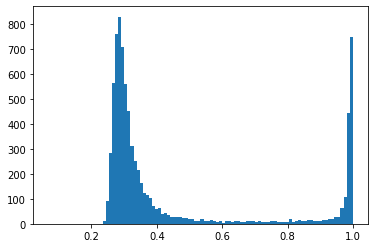

In [112]:
if IS_MAKE_SUB:
    # model pths
    pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
    #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
    print(pths)

    # ==========================================================
    # test inference
    # ==========================================================
    submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")

    ## =============================
    ## tta alb
    ## =============================
    #submit_tta1 = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
    #submit_tta1 = submit_tta1.rename(columns={"preds": "preds_tta1"})
    #
    #submit = pd.merge(submit, submit_tta1[["id", "preds_tta1"]], on="id")
    #submit["preds"] = (submit["preds"].to_numpy() + submit["preds_tta1"].to_numpy()) / 2.0
    ## =============================

    submit["target"] = submit["preds"].to_numpy()
    display(submit.head())
    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test.csv', index=False)
    
    submit = submit[["id", "target"]]
    print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))

    # Write prediction
    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_submission.csv', index=False)
    display(submit)

    plt.hist(submit["target"], bins=100)
    plt.show()
    plt.clf()  # メモリ解放
    plt.close()

In [ ]:
if CFG.is_wandb:
    wandb.finish()

In [ ]:
## submitファイル連結
#if IS_MAKE_SUB:
#    
#    # シュミレーションデータのsubmitファイル
#    _name = CFG.name.replace("_real", "_sim")
#    sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_submission.csv'
#    
#    if os.path.isfile(sim_csv):
#        submit_real = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_submission.csv')
#        submit_sim = pd.read_csv(sim_csv)
#        submit = pd.concat([submit_sim, submit_real])
#        
#        # 行の順番をtest_dfの順番にする
#        test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
#        submit = pd.merge(test_df[["id"]], submit, on="id")
#        
#        submit = submit[["id", "target"]]
#        print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))
#
#        # Write prediction
#        submit.to_csv(OUTPUT_DIR + f'/{CFG.name.split("_real")[0]}_sim_real_submission.csv', index=False)
#        display(submit)
#
#        plt.hist(submit["target"], bins=100)
#        plt.show()
#        plt.clf()  # メモリ解放
#        plt.close()

# Stacking

In [ ]:
#### stacking用にtest set全体で推論
#test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
#test_df["target"] = 0.5
#if cfg_is_npy:
#    test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
#else:
#    test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
#    
#if IS_MAKE_SUB:
#    pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
#    #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
#    
#    submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")
#
#    submit["target"] = submit["preds"].to_numpy()
#    display(submit.head())
#    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv', index=False)

In [ ]:
import joblib
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def set_seed(seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)


def table_train_fn(df, feature_cols, target_col, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    lgb_params = {
            "objective": "binary",
            "learning_rate": 0.03,
            "n_estimators": 100_000,
        }
    
    Y_pred = np.zeros((len(df)))

    for i in tqdm(CFG.seeds):
        print(f"------------ seed:{i} ------------")
        set_seed(seed=i)
        folds = df.copy()

        for j in range(CFG.n_fold):
            print(f"------------ fold:{j} ------------")

            train = folds[folds["fold"] != j]
            val = folds[folds["fold"] == j]
            val_idx = val.index
            
            X_train, X_val = train[feature_cols], val[feature_cols]
            y_train, y_val = train[target_col], val[target_col]
            X_train, X_val = X_train.values, X_val.values
            y_train, y_val = y_train.values, y_val.values

            ### lgb.LGBMClassifier
            #model = lgb.LGBMClassifier(random_state=i, **lgb_params)
            #model.fit(X_train, y_train,
            #          eval_set=[(X_val, y_val)],
            #          eval_metric="error",
            #          early_stopping_rounds=100,
            #          verbose=-1,
            #         )
            
            ### RandomForestClassifier
            #model = RandomForestClassifier(random_state=i)
            #model = model.fit(X_train, y_train)
            
            ### LogisticRegression
            model = LogisticRegression(random_state=i)
            model = model.fit(X_train, y_train)
            
            pred = model.predict_proba(X_val) / len(CFG.seeds)
            Y_pred[val_idx] += pred[:,1]
            
            joblib.dump(model, out_dir + f"/model_seed_{i}_fold_{j}_{target_col}.jlb", compress=True)

    folds["pred"] = Y_pred
    print("oof score:", get_score(folds[target_col].values, folds["pred"].values))
    
    folds.to_csv(out_dir + f"/{target_col}_oof.csv", index=False)
    
    return folds

def table_test_fn(df, feature_cols, target_col, out_dir, model_paths):
    os.makedirs(out_dir, exist_ok=True)
    X = df[feature_cols]
    Y_pred = np.zeros((len(df)))
    for m_p in sorted(model_paths):
        model = joblib.load(m_p)
        
        ### LogisticRegression
        print("model.coef_:", model.coef_)
        
        pred = model.predict_proba(X) / len(model_paths)
        Y_pred += pred[:,1]
    df[target_col] = Y_pred
    df[["id", "target"]].to_csv(out_dir + f"/{target_col}_sub.csv", index=False)
    return df


#### train
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_oof_df_seed{CFG.seeds[0]}.csv'
#if os.path.isfile(sim_csv):
#    sim_oof = pd.read_csv(sim_csv)
#    real_oof = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{CFG.seeds[0]}.csv')
#    stacking_oof = pd.merge(real_oof[["id", "target", "fold", "preds"]], sim_oof[["id", "preds"]], on="id")
#    stacking_oof = stacking_oof.rename(columns={"preds_x":'real_p', "preds_y":'sim_p'})
#    #display(stacking_oof)
#    _ = table_train_fn(stacking_oof, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking")
#
#### test
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_test_all.csv'
#if os.path.isfile(sim_csv):
#    sim_sub = pd.read_csv(sim_csv)
#    real_sub = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv')
#    stacking_sub = pd.merge(real_sub[["id", "target"]], sim_sub[["id", "target"]], on="id")
#    stacking_sub = stacking_sub.rename(columns={"target_x":'real_p', "target_y":'sim_p'})
#    stacking_sub = table_test_fn(stacking_sub, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking", 
#                                 glob.glob(OUTPUT_DIR + "/stacking/*.jlb"))
#    display(stacking_sub)
#    plt.hist(stacking_sub["target"], bins=100)
#    plt.show()
#    plt.clf()  # メモリ解放
#    plt.close()